# Training notebook

## Food Image Classification for the course _Foundations of Deep Learning_.

Professors:
Paolo Napoletano
Marco Buzzelli

Tutor:
Mirko Agarla

## Goal of this notebook

The goal of this notebook is to select the best model in terms of accuracy measure and the corresponding hyperparameters in order to use it for the testing phase.

## Install packages

In [1]:
# INSTALL SCIKERAS, SPLIT-FOLDERS AND ANN VISUALIZER PACKAGES
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import libraries

In [2]:
# IMPORT TENSORFLOW/KERAS
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.mobilenet_v2 import MobileNetV2

# KERAS LAYERS
from keras.layers import Input
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.utils import to_categorical
from keras.layers.core import Activation
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.pooling import GlobalMaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

# SCIKIT-LEARN MODELS/SCIKERAS
from sklearn import preprocessing
import sklearn.metrics as metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, make_scorer

# IMPORT OTHER MODULES
import os
import sys
import glob
import datetime
import fnmatch # to count number of image per folder easily
import random # to select random images from a folder
import numpy as np
import pandas as pd
from os import mkdir
import seaborn as sns
from pathlib import Path
from shutil import copyfile # to import "copyfile"
from numpy.random import seed
import plotly.figure_factory as ff # for printing the heatmap
from collections import defaultdict
from matplotlib import pyplot as plt
import matplotlib.image as img_mat
from IPython.display import Javascript

# CV2
import cv2
from google.colab.patches import cv2_imshow 

In [3]:
# SET RANDOM SEED TO GET, AS MUCH AS POSSIBLE, REPRODUCIBLE RESULTS
# USING NUMPY
seed(42)

# IN ADDITION, WE SET THE RANDOM NUMBER WITH TENSORFLOW BECAUSE IT HAS 
# ITS OWN RANDOM NUMBER GENERATOR THAT MUST ALSO BE SEEDED 
# BY CALLING THE SET_RANDOM_SEED() FUNCTION IMMEDIATELY 
# AFTER THE NUMPY RANDOM NUMBER GENERATOR
tf.random.set_seed(42)

In [4]:
# Link Google Drive account
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# IMPORT UTILS.PY: utils.py contains different useful functions

# 1.Insert the directory
sys.path.insert(0,"/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food")

# 2.Import your module or file
import utils

In [ ]:
# # TRANSFER THE DATA FROM THE GOOGLE DRIVE FOLDER TO THE VIRTUAL MACHINE

# # The first path is the "data" folder on my Google Drive, and the second one is the destination in my current runtime
# # https://stackoverflow.com/questions/67360001/copy-files-from-a-mounted-google-drive-to-a-local-google-colab-session
# !cp -r /content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/Foundation_of_Deep_Learning/Project_Example_Food/ExampleFoodImageDataset /content/ExampleFoodImageDataset

In [6]:
# CONSTANTS
SEED_VALUE = 42
num_classes = 9 # number of output classes
batch_size = 16
SIZE = 224 # size for resizing the images

# DEFINE AN EARLY STOPPING CRITERION
callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights = True)

# PATH TO THE DATA
ORIGINAL_DATA = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset"
PREPROCESSED_DATA = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDatasetPreprocessed"
DIR_TRAIN_TEST_DATA = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test'

# LOAD THE FOLDERS WHERE THE TRAINING/TESTING/VALIDATION DATA ARE STORED
base_path_train = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/train/'
base_path_test = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/test/'
base_path_val = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/val/'

# PATH TO THE DATA
DIR_TRAIN_DATA = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/train/*' # path contenente i sottoinsiemi di train, test
DIR_TEST_DATA = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/test/*' # path contenente i sottoinsiemi di train, test
DIR_VAL_DATA = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/val/*' # path contenente i sottoinsiemi di train, test

In [7]:
# SETTINGS FOR PRETTIER VISUALIZATION IN GOOGLE COLAB
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

In [ ]:
# # REMOVE ANY FOLDER NOT EMPTY IN GOOGLE DRIVE THAT YOU DO NOT NEED
# import shutil

# shutil.rmtree('/content/test')

-----------------------------------

# 1.Model architectures and training phase
This section deals with the models creation, the performance results and the dicussion of them.

## 1.1 Data loader



In any deep learning framework, a data loader takes care of (at least) the following tasks:

- Loading input and target data
- Splitting the dataset into mini batches

In this case, no Data Augmentation on-the-fly is done: 
tf.keras.preprocessing.image_dataset_from_directory generates a tf.data.Dataset from image files in a directory, without any Data Augmentation procedure.

In [ ]:
# RESCALE THE IMAGES
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
# test_datagen = ImageDataGenerator(rescale=1./255) 

# This is a generator that will read pictures found in
# subfolers of 'data/train', and generate
# batches of image data.
# Only deal with the validation data. The test data
# will be used in the TEST NOTEBOOK
train_generator = train_datagen.flow_from_directory(
    base_path_train,
    color_mode='rgb',
    target_size=(SIZE,SIZE),
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",
    seed = SEED_VALUE)

val_generator = val_datagen.flow_from_directory(
    base_path_val,
    color_mode='rgb',
    target_size=(SIZE,SIZE),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
    seed = SEED_VALUE)

<IPython.core.display.Javascript object>

Found 2184 images belonging to 9 classes.
Found 192 images belonging to 9 classes.


## 1.2.1 Model V01

Create the first model to be fed with the image data.

**keras.Input((224, 224, 3))**
- 224 rows, 224 columns, 3 RGB channels

**tf.keras.layers.Conv2D(filters, kernel_size, padding="same")**

- **filters**: 32 filtri
- **kernel_size**: 3x3
- **padding**: mi dice quanti pixel aggiungere di cornice alla mia immagine prima di fare la convoluzione. Se non fornito, l'output della convoluzione produrrà un immagine un pelo più piccola di quella di partenza spazialmente: nel far scorrere la finestra di convoluzione non riesce a coprire l'intorno del pixel di riferimento nell'immagine. Dando "same" il padding viene calcolato automaticamente. 

**keras.layers.Activation('relu')**

- Attivazione **ReLU**: la funzione di attivazione introduce una non linearità. Fa si che il calcolo che permette di trasformare i numeri che stanno nell'input nei numeri che stanno nell'output non sia semplicemente una combinazione lineare dell'input, ma in generale crea un livello di complessità maggiore che è quello di costruire delle astrazioni, ovvero permette alla rete neurale di dire: ok, adesso ho individuato delle linee di base, ora ci costruisco sopra dei ragionamenti più complessi.

**keras.layers.MaxPooling2D(3, strides=3, padding='same')**

- **MaxPooling** con finestre/windows 3x3 e stride di 3: ciò significa che ogni 3x3 valori dell'input li sostituiamo con il suo Max e poi quando spostiamo la finestra che esegue questa operazione, la spostiamo di 3 pixels a destra. Così facendo non contiamo più volte lo stesso input e in questo caso l'output di questo layer sarà per definizione più piccolo spazialmente dell'input. E' un tipo di layer che ci serve concettualmente per essere meno dipendenti da eventuali piccole variazioni nell'input (se ci sono tralazione dei dati di un pixel a destra) il Max Pooling è abbastanza robusto da queste variazioni trascendendo di qualche misura da variazioni dei dati. Tra l'altro se lo usiamo con questo stride diminuisce la dimensione dell'input e la complessità dei valori che portiamo avanti nella rete neurale. Stiamo infatti passando da 224x224x3 valori a 3 numeri. 

**keras.layers.GlobalMaxPooling2D()**

- Equivalente del Max Pooling, il **Global Pooling** invece che basarsi su una finestra 3x3 utilizza una finestra grande quanto l'intera attivazione del layer precedente.

**keras.layers.Dense(num_classes, activation='softmax')**

- Questa **softmax** prende i due numeri (le due classi specificate) e dà in input una funzione che ha lo scopo di produrre una pseudo distrubuzione di probabilità. Si assicura che la somma dei valori (dei due valori nel nostro caso), faccia 1, e introduce delle non linearità.

**keras.Model(inputs, outputs)**

- Con questo comando impacchettiamo tutti i nostri passaggi e diciamo che la mia rete neurale è un modello che parte dalla variabile "inputs" e termina con la variabile chiamata "outputs". 

In [ ]:
# Architecture definition V01
inputs = keras.Input((SIZE, SIZE, 3)) # SIZE rows, SIZE columns, 3 RGB channels

x = inputs

# 1st Conv layer
x = keras.layers.Conv2D(32, 3, padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding='same')(x) 

# 2st Conv layer
x = keras.layers.Conv2D(64, 3, padding = 'same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.GlobalMaxPooling2D()(x)

# Final dense layer
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

net_modelV01 = keras.Model(inputs, outputs)

# SUMMARY
net_modelV01.summary()

<IPython.core.display.Javascript object>

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 activation (Activation)     (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 75, 75, 64)        0         
                                                             

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1epVc7WVGfVZAz38W_S7W25y5C5EQ-uod' />
<figcaption>Architecture ModelV01</figcaption></center>
</figure>

**Compile the model**

We need to compile the model. 
The loss is the *categorical_crossentropy*. 
For each image (input data) it says: let's look at the ground truth. What was the class of the image? It was a cat (first class). Let's see what is the value returned by the neural network (ideally it should be 1). The farther the expected class estimate is from 1, the greater the loss (worst result as the value of Loss increases).

In [ ]:
net_modelV01.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy'])

<IPython.core.display.Javascript object>

Se la volta scorsa (durante le esercitazioni) potevamo permetterci di avere in memoria  tutto il dataset qua non possiamo fare altrettanto perché abbiamo immagini e non c'è modo di caricare tutto il dataset in memoria alla procedura di fit. 
Motivo per il quale stiamo utilizzando il data loader definito all'inizio. avendolo specificato all'inizio il train_dataset prenderà in ingresso 32 (16) immagini alla volta, definito come batch size fino a coprire l'intero dataset.
Cosi facendo ha completato una epoca e tira in ballo il validation data loader che congela momentaneamente l'addestramento della rete neurale, fornisce alla rete tutte le immagini del validation set (anche in questo caso 32 (16) alla volta) e calcola il risultato. e salviamo il risultato nella variabile history.


In [ ]:
# START COUNTING THE TIME
start = datetime.datetime.now()

# FIT THE MODEL
history_modelV01 = net_modelV01.fit(train_generator, 
                  validation_data = val_generator, # test_generator
                  steps_per_epoch = train_generator.n // train_generator.batch_size,
                  validation_steps = val_generator.n // val_generator.batch_size, # test_generator
                  epochs=50,
                  callbacks = [callback])

# STOP COUNTING THE TIME
end = datetime.datetime.now()
print("Total execution time is: ", end-start)

<IPython.core.display.Javascript object>

Epoch 1/50
187/187 [==============================] - 541s 3s/step - loss: 2.2825 - accuracy: 0.1463 - val_loss: 2.2990 - val_accuracy: 0.1500
Epoch 2/50
187/187 [==============================] - 12s 66ms/step - loss: 2.2245 - accuracy: 0.2604 - val_loss: 2.2643 - val_accuracy: 0.1292
Epoch 3/50
187/187 [==============================] - 12s 65ms/step - loss: 2.1600 - accuracy: 0.3333 - val_loss: 2.1987 - val_accuracy: 0.2375
Epoch 4/50
187/187 [==============================] - 12s 65ms/step - loss: 2.0903 - accuracy: 0.3327 - val_loss: 2.1883 - val_accuracy: 0.2083
Epoch 5/50
187/187 [==============================] - 12s 64ms/step - loss: 2.0196 - accuracy: 0.3561 - val_loss: 2.0667 - val_accuracy: 0.2958
Epoch 6/50
187/187 [==============================] - 12s 64ms/step - loss: 1.9483 - accuracy: 0.3772 - val_loss: 2.0127 - val_accuracy: 0.2792
Epoch 7/50
187/187 [==============================] - 12s 65ms/step - loss: 1.8786 - accuracy: 0.3902 - val_loss: 1.9899 - val_accuracy: 

In [ ]:
# # START COUNTING THE TIME
# start = datetime.datetime.now()

# history_modelV01 = net_modelV01.fit(train_dataset, 
#                   epochs=50, 
#                   validation_data = test_dataset,
#                   # steps_per_epoch = n_samples_train_dataset // batch_size, --> https://stackoverflow.com/questions/59864408/tensorflowyour-input-ran-out-of-data
#                   # validation_steps = n_samples_test_dataset // batch_size,
#                   callbacks = [callback])

# # STOP COUNTING THE TIME
# end = datetime.datetime.now()
# print("Total execution time with PCA is: ", end-start)

<IPython.core.display.Javascript object>

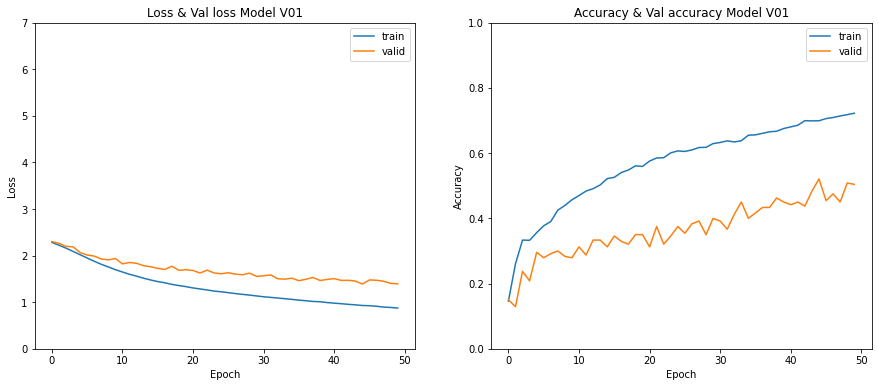

In [ ]:
# PLOT THE LEARNING CURVES
plt.figure(figsize=(15,6))

# LOSS
plt.subplot(1, 2, 1)
plt.plot(history_modelV01.history['loss'])
plt.plot(history_modelV01.history['val_loss'])
plt.ylim([0.0, 7.0])
plt.title("Loss & Val loss Model V01")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

# ACCURACY
plt.subplot(1, 2, 2)
plt.plot(history_modelV01.history['accuracy'])
plt.plot(history_modelV01.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.title("Accuracy & Val accuracy Model V01")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

### Performance results Model V01

The performance in terms of validation accuracy are not better enough with respect to a dummy classifier.

In [ ]:
# SAVE THE TIME NEEDED TO RUN THE ALGORITHM
time_duration_modelV01 = end - start
print(time_duration_modelV01)

<IPython.core.display.Javascript object>

0:22:55.235478


In [ ]:
# GET THE MINIMUM ACCURACY, THE MAXIMUM ACCURACY, THE MINIMUM LOSS, THE MAXIMUM LOSS AND SAVE THEM IN VARIABLES.
# THEN CREATE A DATAFRAME AT THE END OF THE NOTEBOOK WHERE YOU CAN 
# COMPARE DIFFERENT.

# LOSS/VAL LOSS
modelV01_minLoss = min(history_modelV01.history['loss'])
modelV01_maxLoss = max(history_modelV01.history['loss'])
modelV01_minValLoss = min(history_modelV01.history['val_loss'])
modelV01_maxValLoss = max(history_modelV01.history['val_loss'])

# ACCURACY/VAL ACCURACY
modelV01_minAccuracy = min(history_modelV01.history['accuracy'])
modelV01_maxAccuracy = max(history_modelV01.history['accuracy'])
modelV01_minValAccuracy = min(history_modelV01.history['val_accuracy'])
modelV01_maxValAccuracy = max(history_modelV01.history['val_accuracy'])

# CREATE THE DATAFRAME
modelV01_loss_accuracy = pd.DataFrame({"minLoss": [modelV01_minLoss],
                                       "maxloss": [modelV01_maxLoss],
                                       "minValLoss": [modelV01_minValLoss],
                                       "maxValLoss": [modelV01_maxValLoss],
                                       "minAccuracy": [modelV01_minAccuracy],
                                       "maxAccuracy": [modelV01_maxAccuracy],
                                       "minValAccuracy": [modelV01_minValAccuracy],
                                       "maxValAccuracy": [modelV01_maxValAccuracy]}).T

# CHANGE THE FIRST COLUMN NAME
modelV01_loss_accuracy = modelV01_loss_accuracy.rename(columns={0: 'modelV01'})
# CHANGE THE INDEX NAME
modelV01_loss_accuracy.index.names = ['Performance']
modelV01_loss_accuracy

<IPython.core.display.Javascript object>

,modelV01
Performance,
minLoss,0.874946
maxloss,2.282531
minValLoss,1.389947
maxValLoss,2.299038
minAccuracy,0.146252
maxAccuracy,0.722222
minValAccuracy,0.129167
maxValAccuracy,0.520833


## 1.2.2 Model V02 - Model with regularization, Batch normalization and double Dense layer

Create the second model to be fed with the image data.

In [ ]:
# Architecture definition V02
inputs = keras.Input((SIZE,SIZE,3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

x = keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

net_modelV02 = keras.Model(inputs, outputs)

net_modelV02.summary()

<IPython.core.display.Javascript object>

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 activation_2 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 64)        1849

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1qKA348F045qujsBUp-TlWSui43jTvVM5' />
<figcaption>Architecture ModelV02</figcaption></center>
</figure>

In [ ]:
# COMPILE THE MODEL
net_modelV02.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy'])

<IPython.core.display.Javascript object>

In [ ]:
# START COUNTING THE TIME
start = datetime.datetime.now()

# FIT THE MODEL
history_modelV02 = net_modelV02.fit(train_generator, 
                  validation_data = val_generator, # test_generator
                  steps_per_epoch = train_generator.n // train_generator.batch_size,
                  validation_steps = val_generator.n // val_generator.batch_size, # test_generator
                  epochs=50,
                  callbacks = [callback])

# STOP COUNTING THE TIME
end = datetime.datetime.now()
print("Total execution time is: ", end-start)

<IPython.core.display.Javascript object>

Epoch 1/50
187/187 [==============================] - 13s 67ms/step - loss: 2.2745 - accuracy: 0.4043 - val_loss: 2.5471 - val_accuracy: 0.1958
Epoch 2/50
187/187 [==============================] - 12s 65ms/step - loss: 1.3454 - accuracy: 0.6560 - val_loss: 2.4092 - val_accuracy: 0.2333
Epoch 3/50
187/187 [==============================] - 12s 65ms/step - loss: 1.1015 - accuracy: 0.7533 - val_loss: 1.8696 - val_accuracy: 0.4333
Epoch 4/50
187/187 [==============================] - 12s 65ms/step - loss: 0.9620 - accuracy: 0.8025 - val_loss: 1.7053 - val_accuracy: 0.5125
Epoch 5/50
187/187 [==============================] - 12s 65ms/step - loss: 0.8454 - accuracy: 0.8504 - val_loss: 1.5718 - val_accuracy: 0.5333
Epoch 6/50
187/187 [==============================] - 12s 65ms/step - loss: 0.7486 - accuracy: 0.8775 - val_loss: 1.4384 - val_accuracy: 0.6000
Epoch 7/50
187/187 [==============================] - 12s 66ms/step - loss: 0.6755 - accuracy: 0.9039 - val_loss: 1.4035 - val_accuracy:

In [ ]:
# # START COUNTING THE TIME
# start = datetime.datetime.now()

# history_modelV02 = net_modelV02.fit(train_dataset, 
#                            epochs=50, 
#                            validation_data = test_dataset,
#                            callbacks = [callback])

# # STOP COUNTING THE TIME
# end = datetime.datetime.now()
# print("Total execution time with PCA is: ", end-start)

<IPython.core.display.Javascript object>

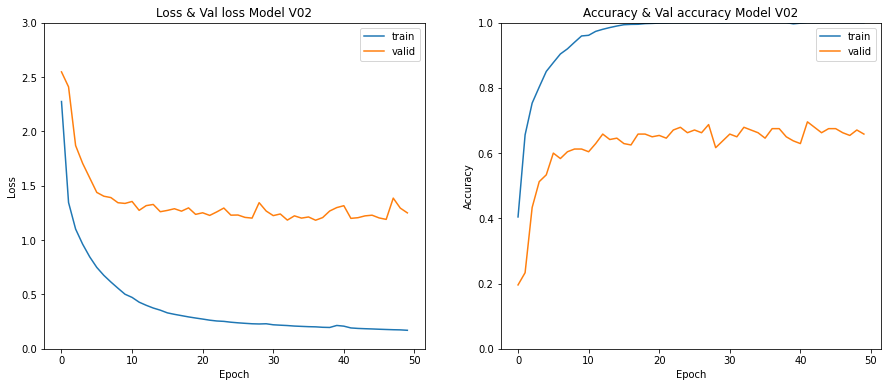

In [ ]:
# PLOT THEM TOGETHER
# Visualization of the learning curves
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(history_modelV02.history['loss'])
plt.plot(history_modelV02.history['val_loss'])
plt.ylim([0.0, 3.0])
plt.title("Loss & Val loss Model V02")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history_modelV02.history['accuracy'])
plt.plot(history_modelV02.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.title("Accuracy & Val accuracy Model V02")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

### Performance results Model V02

The model performs sligthly better than the first one, but not enough to be used as a final classifier.

In [ ]:
# SAVE THE TIME NEEDED TO RUN THE ALGORITHM
time_duration_modelV02 = end - start
print(time_duration_modelV02)

<IPython.core.display.Javascript object>

0:14:02.011928


In [ ]:
# GET THE MINIMUM ACCURACY, THE MAXIMUM ACCURACY, THE MINIMUM LOSS, THE MAXIMUM LOSS AND SAVE THEM IN VARIABLES.
# THEN CREATE A DATAFRAME AT THE END WHERE YOU CAN COMPARE DIFFERENT MODELS WITH IT!

# LOSS/VAL LOSS
modelV02_minLoss = min(history_modelV02.history['loss'])
modelV02_maxLoss = max(history_modelV02.history['loss'])
modelV02_minValLoss = min(history_modelV02.history['val_loss'])
modelV02_maxValLoss = max(history_modelV02.history['val_loss'])

# ACCURACY/VAL ACCURACY
modelV02_minAccuracy = min(history_modelV02.history['accuracy'])
modelV02_maxAccuracy = max(history_modelV02.history['accuracy'])
modelV02_minValAccuracy = min(history_modelV02.history['val_accuracy'])
modelV02_maxValAccuracy = max(history_modelV02.history['val_accuracy'])

# CREATE THE DATAFRAME
modelV02_loss_accuracy = pd.DataFrame({"minLoss": [modelV02_minLoss],
                                       "maxloss": [modelV02_maxLoss],
                                       "minValLoss": [modelV02_minValLoss],
                                       "maxValLoss": [modelV02_maxValLoss],
                                       "minAccuracy": [modelV02_minAccuracy],
                                       "maxAccuracy": [modelV02_maxAccuracy],
                                       "minValAccuracy": [modelV02_minValAccuracy],
                                       "maxValAccuracy": [modelV02_maxValAccuracy]}).T

# CHANGE THE FIRST COLUMN NAME
modelV02_loss_accuracy = modelV02_loss_accuracy.rename(columns={0: 'modelV02'})
# CHANGE THE INDEX NAME
modelV02_loss_accuracy.index.names = ['Performance']
modelV02_loss_accuracy

<IPython.core.display.Javascript object>

,modelV02
Performance,
minLoss,0.170244
maxloss,2.274471
minValLoss,1.182631
maxValLoss,2.547081
minAccuracy,0.404284
maxAccuracy,1.000000
minValAccuracy,0.195833
maxValAccuracy,0.695833


## 1.2.3 Model V03 - Training the model with Data Agmentation from keras (regularization and dropout)

Create the third model to be fed with the image data.

In [ ]:
# DATA AUGMENTATION ONLY ON THE TRAINING SET
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,
        rotation_range=45,
        fill_mode='nearest')  # randomly shift images vertically (fraction of total height))

# this is the augmentation configuration we will use for testing:
# only rescaling
# test_datagen = ImageDataGenerator(rescale=1./255) 
val_datagen = ImageDataGenerator(rescale=1./255) 

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
    base_path_train,
    target_size=(SIZE,SIZE),
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",
    seed = SEED_VALUE)

# test_generator = test_datagen.flow_from_directory(
#     base_path_test,
#     target_size=(SIZE,SIZE),
#     batch_size=batch_size,
#     shuffle=False,
#     class_mode="categorical",
#     seed = SEED_VALUE)

val_generator = val_datagen.flow_from_directory(
    base_path_val,
    target_size=(SIZE,SIZE),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
    seed = SEED_VALUE)

<IPython.core.display.Javascript object>

Found 3004 images belonging to 10 classes.
Found 242 images belonging to 10 classes.


In [ ]:
# ARCHITECTURE DEFINITION FOR MODEL V03
inputs = keras.Input((SIZE,SIZE,3))

x = inputs

x = keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(512, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.GlobalMaxPooling2D()(x)

# ADD FLATTEN LAYER
x = tf.keras.layers.Flatten()(x)
# ADD DROPOUT LAYER
x = keras.layers.Dropout(.15)(x)

x = keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

net_modelV03 = keras.Model(inputs, outputs)

# PRINT THE SUMMARY
net_modelV03.summary()

<IPython.core.display.Javascript object>

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_3 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 64)        1849

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1WMiCo7jjyvtIw3VJW0T0aUDjBMC8Dyaq' />
<figcaption>Architecture ModelV03</figcaption></center>
</figure>

In [ ]:
# COMPILE THE MODEL
net_modelV03.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy'])

<IPython.core.display.Javascript object>

In [ ]:
# START COUNTING THE TIME
start = datetime.datetime.now()

# FIT THE MODEL
history_modelV03 = net_modelV03.fit(train_generator, 
                  validation_data = val_generator, # test_generator
                  steps_per_epoch = train_generator.n // train_generator.batch_size,
                  validation_steps = val_generator.n // val_generator.batch_size, # test_generator
                  epochs=50,
                  callbacks = [callback])

# STOP COUNTING THE TIME
end = datetime.datetime.now()
print("Total execution time with PCA is: ", end-start)

<IPython.core.display.Javascript object>

Epoch 1/50
187/187 [==============================] - 47s 245ms/step - loss: 3.8601 - accuracy: 0.4418 - val_loss: 4.9987 - val_accuracy: 0.1250
Epoch 2/50
187/187 [==============================] - 43s 231ms/step - loss: 3.3221 - accuracy: 0.6128 - val_loss: 3.6677 - val_accuracy: 0.4917
Epoch 3/50
187/187 [==============================] - 41s 218ms/step - loss: 3.1141 - accuracy: 0.6821 - val_loss: 3.4573 - val_accuracy: 0.5458
Epoch 4/50
187/187 [==============================] - 40s 215ms/step - loss: 2.9469 - accuracy: 0.7349 - val_loss: 3.6121 - val_accuracy: 0.5417
Epoch 5/50
187/187 [==============================] - 40s 216ms/step - loss: 2.8523 - accuracy: 0.7547 - val_loss: 3.5009 - val_accuracy: 0.5292
Epoch 6/50
187/187 [==============================] - 40s 216ms/step - loss: 2.7048 - accuracy: 0.7979 - val_loss: 3.3731 - val_accuracy: 0.6250
Epoch 7/50
187/187 [==============================] - 42s 222ms/step - loss: 2.6341 - accuracy: 0.8173 - val_loss: 3.2209 - val_ac

In [ ]:
# Iterazioni (numero al di sotto delle epoche) viene calcolato come shape del training (in termini di lunghezza)/numero di epoche.
# Esempio: se lunghezza di training è 1803 la si divide per batch size di 64 e si ottiene 28 iterazioni per epoca! --> to see all 
# the datapoints it need 28 iterations.

In [ ]:
# SHOW DIFFERENT TRAINING EPOCHS: USE 40/70/100 TRAINING EPOCHS AND SHOW/COMMENT THE RESULTS!
# UTILE PER CAPIRE STEPS PER EPOCH AND VALIDATION STEPS: https://datascience.stackexchange.com/questions/47405/what-to-set-in-steps-per-epoch-in-keras-fit-generator

<IPython.core.display.Javascript object>

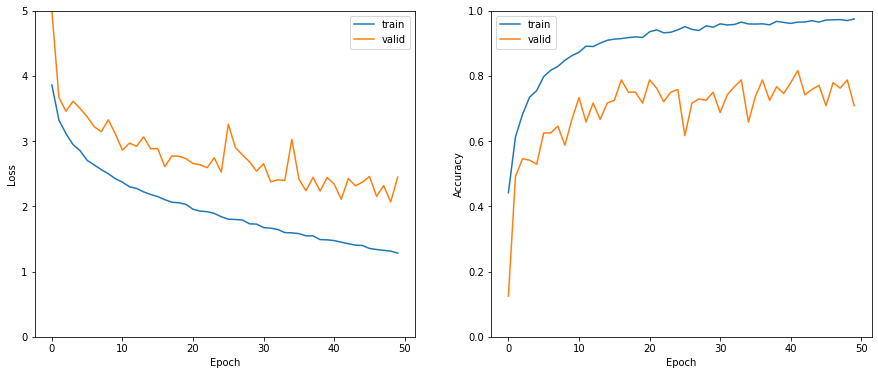

In [ ]:
# VISUALIZATION OF THE LEARNING CURVES
plt.figure(figsize=(15,6))

# VISUALIZZIAMO NUOVAMENTE L'OUTPUT IN TERMINI DI LOSS FUNCTION
plt.subplot(1, 2, 1)
plt.plot(history_modelV03.history['loss'])
plt.plot(history_modelV03.history['val_loss'])
plt.ylim([0.0, 5.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history_modelV03.history['accuracy'])
plt.plot(history_modelV03.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

### Performance results Model V03

In [ ]:
# SAVE THE TIME NEEDED TO RUN THE ALGORITHM
time_duration_modelV03 = end - start
print(time_duration_modelV03)

<IPython.core.display.Javascript object>

0:17:07.901522


In [ ]:
# GET THE MINIMUM ACCURACY, THE MAXIMUM ACCURACY, THE MINIMUM LOSS, THE MAXIMUM LOSS AND SAVE THEM IN VARIABLES.
# THEN CREATE A DATAFRAME AT THE END WHERE YOU CAN COMPARE DIFFERENT MODELS WITH IT!

# LOSS/VAL LOSS
modelV03_minLoss = min(history_modelV03.history['loss'])
modelV03_maxLoss = max(history_modelV03.history['loss'])
modelV03_minValLoss = min(history_modelV03.history['val_loss'])
modelV03_maxValLoss = max(history_modelV03.history['val_loss'])

# ACCURACY/VAL ACCURACY
modelV03_minAccuracy = min(history_modelV03.history['accuracy'])
modelV03_maxAccuracy = max(history_modelV03.history['accuracy'])
modelV03_minValAccuracy = min(history_modelV03.history['val_accuracy'])
modelV03_maxValAccuracy = max(history_modelV03.history['val_accuracy'])

# CREATE THE DATAFRAME
modelV03_loss_accuracy = pd.DataFrame({"minLoss": [modelV03_minLoss],
                                       "maxloss": [modelV03_maxLoss],
                                       "minValLoss": [modelV03_minValLoss],
                                       "maxValLoss": [modelV03_maxValLoss],
                                       "minAccuracy": [modelV03_minAccuracy],
                                       "maxAccuracy": [modelV03_maxAccuracy],
                                       "minValAccuracy": [modelV03_minValAccuracy],
                                       "maxValAccuracy": [modelV03_maxValAccuracy]}).T

# CHANGE THE FIRST COLUMN NAME
modelV03_loss_accuracy = modelV03_loss_accuracy.rename(columns={0: 'modelV03'})
# CHANGE THE INDEX NAME
modelV03_loss_accuracy.index.names = ['Performance']
modelV03_loss_accuracy

<IPython.core.display.Javascript object>

,modelV03
Performance,
minLoss,1.321285
maxloss,3.802938
minValLoss,2.197832
maxValLoss,4.370973
minAccuracy,0.456158
maxAccuracy,0.971218
minValAccuracy,0.187500
maxValAccuracy,0.808333


EXAMPLE OF NOTES THAT YOU CAN ADD:

Note:

- The increased complexity does not appear to have improved the capability of the network.
- It has, however, impacted the validation accuracy curve, which is now converging faster.
- We will now address the current behavior to implement an early stopping mechanism.

Check the following:
- https://stackoverflow.com/questions/49017331/keras-flow-from-directorydirectory
- https://studymachinelearning.com/keras-imagedatagenerator-with-flow_from_directory/

---------------------

## 1.2.4 MODEL V04 - Training the model with Data Agmentation from keras (regularization and higher dropout) - Deeper model

In [ ]:
# ARCHITECTURE FOUND AT: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
inputs = keras.Input((SIZE,SIZE,3))

x = inputs

x = keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(512, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.GlobalMaxPooling2D()(x)

# the model so far outputs 3D feature maps (height, width, features)

# FLATTEN AND ADD DROPOUT
x = tf.keras.layers.Flatten()(x) # this converts our 3D feature maps to 1D feature vectors
x = keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.Dropout(.20)(x)
x = keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

net_modelv04 = keras.Model(inputs, outputs)

net_modelv04.summary()

<IPython.core.display.Javascript object>

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_13 (Bat  (None, 96, 96, 32)       128       
 chNormalization)                                                
                                                                 
 activation_17 (Activation)  (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        9248

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1Zwvj-ZS4q82tea6xj7WHNNqhw_uOzd5U' />
<figcaption>Architecture ModelV03</figcaption></center>
</figure>

In [ ]:
net_modelv04.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy'])

<IPython.core.display.Javascript object>

In [ ]:
# START COUNTING THE TIME
start = datetime.datetime.now()

history_modelv04 = net_modelv04.fit(
    train_generator,
    steps_per_epoch = train_generator.n // train_generator.batch_size,
    epochs=50,
    validation_data = test_generator,
    validation_steps = test_generator.n // test_generator.batch_size,
    callbacks = [callback])

# STOP COUNTING THE TIME
end = datetime.datetime.now()
print("Total execution time with PCA is: ", end-start)

# model_keras.save_weights('first_try.h5')  # always save your weights after training or during training

<IPython.core.display.Javascript object>

Epoch 1/50
187/187 [==============================] - 18s 87ms/step - loss: 4.3858 - accuracy: 0.3752 - val_loss: 4.5087 - val_accuracy: 0.1094
Epoch 2/50
187/187 [==============================] - 16s 84ms/step - loss: 3.4510 - accuracy: 0.5284 - val_loss: 3.7645 - val_accuracy: 0.3672
Epoch 3/50
187/187 [==============================] - 17s 89ms/step - loss: 3.0286 - accuracy: 0.5997 - val_loss: 3.4219 - val_accuracy: 0.4453
Epoch 4/50
187/187 [==============================] - 16s 84ms/step - loss: 2.8168 - accuracy: 0.6402 - val_loss: 3.4943 - val_accuracy: 0.3906
Epoch 5/50
187/187 [==============================] - 16s 84ms/step - loss: 2.6481 - accuracy: 0.6857 - val_loss: 3.4253 - val_accuracy: 0.4453
Epoch 6/50
187/187 [==============================] - 16s 84ms/step - loss: 2.5365 - accuracy: 0.7075 - val_loss: 3.2187 - val_accuracy: 0.4609
Epoch 7/50
187/187 [==============================] - 16s 84ms/step - loss: 2.4471 - accuracy: 0.7279 - val_loss: 3.2284 - val_accuracy:

<IPython.core.display.Javascript object>

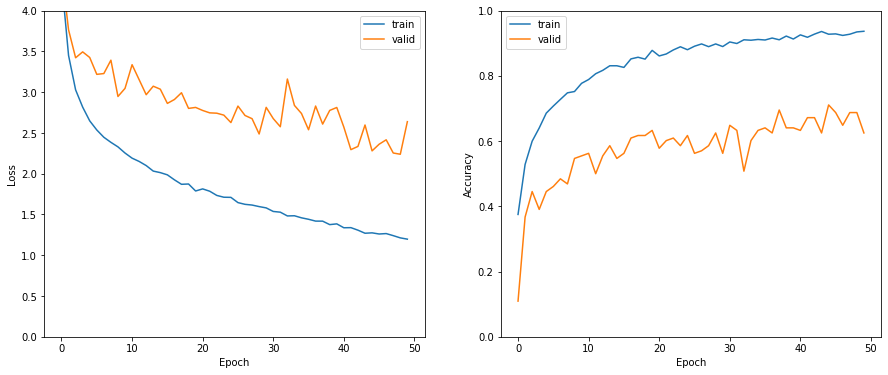

In [ ]:
# PLOT THEM TOGETHER
# Visualization of the learning curves
plt.figure(figsize=(15,6))

# VISUALIZZIAMO NUOVAMENTE L'OUTPUT IN TERMINI DI LOSS FUNCTION
plt.subplot(1, 2, 1)
plt.plot(history_modelv04.history['loss'])
plt.plot(history_modelv04.history['val_loss'])
plt.ylim([0.0, 4.0]) # è difficile da dire a priori
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history_modelv04.history['accuracy'])
plt.plot(history_modelv04.history['val_accuracy'])
plt.ylim([0.0, 1.0]) # 0.5 è il minimo sindacale - dummy classifier fa 50% - fino al massimo 1. 
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

### Performance results Model V04

In [ ]:
# SAVE THE TIME NEEDED TO RUN THE ALGORITHM
time_duration_modelV04 = end - start
print(time_duration_modelV04)

<IPython.core.display.Javascript object>

0:14:54.412495


In [ ]:
# GET THE MINIMUM ACCURACY, THE MAXIMUM ACCURACY, THE MINIMUM LOSS, THE MAXIMUM LOSS AND SAVE THEM IN VARIABLES.
# THEN CREATE A DATAFRAME AT THE END WHERE YOU CAN COMPARE DIFFERENT MODELS WITH IT!

# LOSS/VAL LOSS
modelV04_minLoss = min(history_modelv04.history['loss'])
modelV04_maxLoss = max(history_modelv04.history['loss'])
modelV04_minValLoss = min(history_modelv04.history['val_loss'])
modelV04_maxValLoss = max(history_modelv04.history['val_loss'])

# ACCURACY/VAL ACCURACY
modelV04_minAccuracy = min(history_modelv04.history['accuracy'])
modelV04_maxAccuracy = max(history_modelv04.history['accuracy'])
modelV04_minValAccuracy = min(history_modelv04.history['val_accuracy'])
modelV04_maxValAccuracy = max(history_modelv04.history['val_accuracy'])

# CREATE THE DATAFRAME
modelV04_loss_accuracy = pd.DataFrame({"minLoss": [modelV04_minLoss],
                                       "maxloss": [modelV04_maxLoss],
                                       "minValLoss": [modelV04_minValLoss],
                                       "maxValLoss": [modelV04_maxValLoss],
                                       "minAccuracy": [modelV04_minAccuracy],
                                       "maxAccuracy": [modelV04_maxAccuracy],
                                       "minValAccuracy": [modelV04_minValAccuracy],
                                       "maxValAccuracy": [modelV04_maxValAccuracy]}).T

# CHANGE THE FIRST COLUMN NAME
modelV04_loss_accuracy = modelV04_loss_accuracy.rename(columns={0: 'modelV04'})
# CHANGE THE INDEX NAME
modelV04_loss_accuracy.index.names = ['Performance']
modelV04_loss_accuracy

<IPython.core.display.Javascript object>

,modelV04
Performance,
minLoss,1.197597
maxloss,4.385833
minValLoss,2.238805
maxValLoss,4.508698
minAccuracy,0.375167
maxAccuracy,0.936747
minValAccuracy,0.109375
maxValAccuracy,0.710938


## 1.2.5 Model V05 - GRIDSEARCHCV

GridSearchCV helps to loop through a predefined set of hyperparameters in order to fit the model on your training set. Doing so, you can select the best parameters from the listed hyperparameters and automatically refit the model on those best ones that give you the highest accuracy value.

The *gridsearchcv* function applies also the cross-validation procedure: different portions of the data are used to train and test the model in order to feed it not only with one single portion of it. This technique should prevents the model to see only a specific chunck of the data.

### Parameters tuning

In [ ]:
# USE THE FLOW FROM DIRECTORY ONLY FOR THE TRAIN BECAUSE THE GRIDSEARCHCV METHOD
# WILL CREATE ITS OWN TEST SET
itr = train_datagen.flow_from_directory(
    base_path_train,
    target_size=(SIZE,SIZE),
    batch_size=3004, # you flow through the entire training dataset and get all the images, using just one batch size!
    class_mode='categorical')

X, y = itr.next()

<IPython.core.display.Javascript object>

Found 3004 images belonging to 10 classes.


Create the function *create_GSCV_model()* in order to create the model.

In [ ]:
def create_GSCV_model(lr= 0.1, 
                      init_mode="he_uniform", 
                      activation = 'relu', 
                      dropout_rate= 0.0, 
                      optimizer = 'Adam'):
  
  model_gridsearchCV = tf.keras.models.Sequential([
  keras.Input((SIZE, SIZE, 3)),

  # 1st Conv Block
  keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  keras.layers.MaxPooling2D(3, strides=3, padding="same"),

  # 2nd Conv Block
  keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  keras.layers.MaxPooling2D(3, strides=3, padding="same"),

  # 3rd Conv block
  keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  keras.layers.MaxPooling2D(3, strides=3, padding="same"),

  # 4rd Conv block
  keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  keras.layers.MaxPooling2D(3, strides=3, padding="same"),

  # 5th Conv block
  keras.layers.Conv2D(128, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  keras.layers.MaxPooling2D(3, strides=3, padding="same"),

  # 6th Conv block
  keras.layers.Conv2D(128, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  keras.layers.MaxPooling2D(3, strides=3, padding="same"),

  # 7th Conv block
  keras.layers.Conv2D(512, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),

  # the model so far outputs 3D feature maps (height, width, features)

  # FLATTEN AND ADD DROPOUT
  keras.layers.Flatten(), # this converts our 3D feature maps to 1D feature vectors
  keras.layers.Dropout(0.20),
  keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),

  keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))
  ])

  # COMPILE THE MODEL
  model_gridsearchCV.compile(loss=keras.losses.categorical_crossentropy,
                             optimizer= keras.optimizers.Adam(learning_rate=lr),
                             metrics=['accuracy'],
                             steps_per_execution=5)

  return model_gridsearchCV

create_GSCV_model().summary()

<IPython.core.display.Javascript object>

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_193 (Conv2D)         (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_189 (Ba  (None, 96, 96, 32)       128       
 tchNormalization)                                               
                                                                 
 activation_193 (Activation)  (None, 96, 96, 32)       0         
                                                                 
 max_pooling2d_164 (MaxPooli  (None, 32, 32, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_194 (Conv2D)         (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_190 (Ba  (None, 32, 32, 32)     

In [ ]:
# CREATE THE MODEL
model_gridsearchcv = KerasClassifier(model = create_GSCV_model, # model = create_GSCV_model(), 
                                     epochs = 50,  
                                     lr = 0.1,
                                     verbose = 10,
                                     activation = 'relu',
                                     optimizer='Adam')

<IPython.core.display.Javascript object>

In [ ]:
# DEFINE THE GRID SEARCH PARAMETERS
# batch_size = [16, 32]
optimizer = ['SGD', 'Adam']
lr = [0.001, 0.0001]
activation = ['relu', 'LeakyRelu']

# DEFINE THE SCORE DICTIONARY
scorers = { 
            # 'recall_score': make_scorer(recall_score, average='micro')
            'accuracy_score': make_scorer(accuracy_score)
          }

# DEFINE THE DICTIONARY PARAMETERS
param_grid_CV = {
    # 'batch_size': batch_size,
    'optimizer': optimizer,
    'lr': lr,
    'activation': activation
}

# DEFINE THE GRIDSEARCHCV METHOD
# n_iter_search = 32 
grid_cv = RandomizedSearchCV(estimator = model_gridsearchcv, 
                             param_distributions = param_grid_CV, 
                             scoring=scorers,
                            #  refit='recall_score',
                             refit='accuracy_score',
                             n_jobs = 1,
                            #  n_iter=n_iter_search,
                             cv = 3, 
                             error_score = "raise")

grid_cv

<IPython.core.display.Javascript object>

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=KerasClassifier(activation='relu', epochs=50, lr=0.1, model=<function create_GSCV_model at 0x7feefa203310>, optimizer='Adam', verbose=10),
                   n_jobs=1,
                   param_distributions={'activation': ['relu', 'LeakyRelu'],
                                        'lr': [0.001, 0.0001],
                                        'optimizer': ['SGD', 'Adam']},
                   refit='accuracy_score',
                   scoring={'accuracy_score': make_scorer(accuracy_score)})

In [ ]:
# START COUNTING THE TIME
start = datetime.datetime.now()

# FIT THE GRIDSEARCH MODEL
grid_fit = grid_cv.fit(X, y)

# STOP COUNTING THE TIME
end = datetime.datetime.now()
print("Total execution time is: ", end-start)

<IPython.core.display.Javascript object>

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/5

In [ ]:
# SUMMARIZE RESULTS AND SHOW BEST VALUES

print("Best: %f using %s" % (grid_fit.best_score_, grid_fit.best_params_))
means = grid_fit.cv_results_['mean_test_accuracy_score']
stds = grid_fit.cv_results_['std_test_accuracy_score']
params = grid_fit.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

<IPython.core.display.Javascript object>

Best: 0.819745 using {'optimizer': 'Adam', 'lr': 0.0001, 'activation': 'relu'}
0.782030 (0.019165) with: {'optimizer': 'SGD', 'lr': 0.001, 'activation': 'relu'}
0.755962 (0.049103) with: {'optimizer': 'Adam', 'lr': 0.001, 'activation': 'relu'}
0.800887 (0.024163) with: {'optimizer': 'SGD', 'lr': 0.0001, 'activation': 'relu'}
0.819745 (0.023933) with: {'optimizer': 'Adam', 'lr': 0.0001, 'activation': 'relu'}
0.711037 (0.054720) with: {'optimizer': 'SGD', 'lr': 0.001, 'activation': 'LeakyRelu'}
0.632834 (0.116317) with: {'optimizer': 'Adam', 'lr': 0.001, 'activation': 'LeakyRelu'}
0.806434 (0.003419) with: {'optimizer': 'SGD', 'lr': 0.0001, 'activation': 'LeakyRelu'}
0.819190 (0.008734) with: {'optimizer': 'Adam', 'lr': 0.0001, 'activation': 'LeakyRelu'}


### Performance results Model V05

In [ ]:
# SAVE THE TIME NEEDED TO RUN THE ALGORITHM
time_duration_modelV05_gridsearchcv = end - start
print(time_duration_modelV05_gridsearchcv)

<IPython.core.display.Javascript object>

0:11:02.248361


## 1.2.6 MODEL V04_GRIDSEARCHCV - Retraining with best gridsearchCV parameters founded.

In this case we are retraining the model V04 with the best parameters obtained in model V05 in order to be able to show also all the metrics that we already saved for the other models.

In [ ]:
# BEST PARAMETERS
batch_size_CV = 16
optimizer_CV = 'Adam'
learning_rate_CV = 0.0001
activation_CV = 'relu'

<IPython.core.display.Javascript object>

In [ ]:
# # DATA AUGMENTATION ONLY ON THE TRAINING SET
# train_datagen_CV = ImageDataGenerator(
#         rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.1,
#         horizontal_flip=True,
#         width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.1,
#         rotation_range=45,
#         fill_mode='nearest')  # randomly shift images vertically (fraction of total height))

# # this is the augmentation configuration we will use for testing:
# # only rescaling
# test_datagen_CV = ImageDataGenerator(rescale=1./255) 
# val_datagen_CV = ImageDataGenerator(rescale=1./255) 

# # this is a generator that will read pictures found in
# # subfolers of 'data/train', and indefinitely generate
# # batches of augmented image data
# train_generator_CV = train_datagen_CV.flow_from_directory(
#     base_path_train,
#     target_size=(SIZE,SIZE),
#     batch_size=batch_size_CV,
#     shuffle=True,
#     class_mode="categorical",
#     seed = SEED_VALUE)

# test_generator_CV = test_datagen_CV.flow_from_directory(
#     base_path_test,
#     target_size=(SIZE,SIZE),
#     batch_size=batch_size_CV,
#     shuffle=False,
#     class_mode="categorical",
#     seed = SEED_VALUE)

# val_generator_CV = val_datagen_CV.flow_from_directory(
#     base_path_val,
#     target_size=(SIZE,SIZE),
#     batch_size=batch_size_CV,
#     shuffle=False,
#     class_mode="categorical",
#     seed = SEED_VALUE)

<IPython.core.display.Javascript object>

Found 3004 images belonging to 10 classes.
Found 132 images belonging to 10 classes.
Found 242 images belonging to 10 classes.


In [ ]:
# ARCHITECTURE FOUND AT: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
inputs = keras.Input((SIZE,SIZE,3))

x = inputs

x = keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(activation_CV)(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(activation_CV )(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(activation_CV)(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(activation_CV)(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(activation_CV)(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(activation_CV)(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(512, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(activation_CV)(x)
x = keras.layers.GlobalMaxPooling2D()(x)

# the model so far outputs 3D feature maps (height, width, features)

# FLATTEN AND ADD DROPOUT
x = tf.keras.layers.Flatten()(x) # this converts our 3D feature maps to 1D feature vectors
x = keras.layers.Dense(512, activation=activation_CV, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.Activation(activation_CV)(x)
x = keras.layers.Dropout(.15)(x)
x = keras.layers.Dense(512, activation=activation_CV, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

net_modelvGSCV = keras.Model(inputs, outputs)

net_modelvGSCV.summary()

<IPython.core.display.Javascript object>

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_57 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_382 (Conv2D)         (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_378 (Ba  (None, 96, 96, 32)       128       
 tchNormalization)                                               
                                                                 
 activation_382 (Activation)  (None, 96, 96, 32)       0         
                                                                 
 max_pooling2d_326 (MaxPooli  (None, 32, 32, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_383 (Conv2D)         (None, 32, 32, 32)        9248

In [ ]:
net_modelvGSCV.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.Adam(learning_rate=learning_rate_CV),
            metrics=['accuracy'])

<IPython.core.display.Javascript object>

In [ ]:
# START COUNTING THE TIME
start = datetime.datetime.now()

history_modelv04_CV = net_modelvGSCV.fit(
        train_generator,
        epochs=50, 
        steps_per_epoch = train_generator.n // train_generator.batch_size,
        validation_data = val_generator,
        validation_steps = val_generator.n // val_generator.batch_size,
        callbacks = [callback])

# STOP COUNTING THE TIME
end = datetime.datetime.now()
print("Total execution time is: ", end-start)

<IPython.core.display.Javascript object>

Epoch 1/50
187/187 [==============================] - 26s 131ms/step - loss: 4.4170 - accuracy: 0.3454 - val_loss: 4.4760 - val_accuracy: 0.1875
Epoch 2/50
187/187 [==============================] - 16s 87ms/step - loss: 3.4726 - accuracy: 0.5348 - val_loss: 3.6148 - val_accuracy: 0.4219
Epoch 3/50
187/187 [==============================] - 16s 88ms/step - loss: 3.0499 - accuracy: 0.5977 - val_loss: 3.3170 - val_accuracy: 0.5469
Epoch 4/50
187/187 [==============================] - 16s 87ms/step - loss: 2.8065 - accuracy: 0.6476 - val_loss: 3.1150 - val_accuracy: 0.4922
Epoch 5/50
187/187 [==============================] - 17s 91ms/step - loss: 2.6400 - accuracy: 0.6847 - val_loss: 3.2305 - val_accuracy: 0.4688
Epoch 6/50
187/187 [==============================] - 16s 88ms/step - loss: 2.5359 - accuracy: 0.7132 - val_loss: 3.1744 - val_accuracy: 0.5156
Epoch 7/50
187/187 [==============================] - 17s 93ms/step - loss: 2.4604 - accuracy: 0.7306 - val_loss: 3.1692 - val_accuracy

<IPython.core.display.Javascript object>

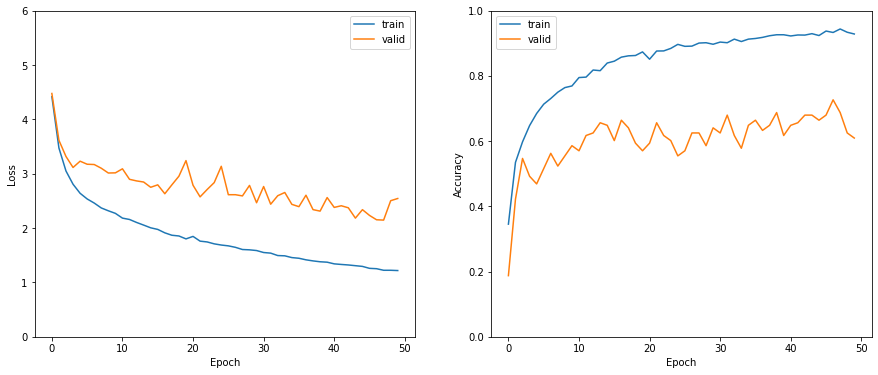

In [ ]:
# PLOT THEM TOGETHER
# Visualization of the learning curves
plt.figure(figsize=(15,6))

# VISUALIZZIAMO NUOVAMENTE L'OUTPUT IN TERMINI DI LOSS FUNCTION
plt.subplot(1, 2, 1)
plt.plot(history_modelv04_CV.history['loss'])
plt.plot(history_modelv04_CV.history['val_loss'])
plt.ylim([0.0, 6.0]) # è difficile da dire a priori
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history_modelv04_CV.history['accuracy'])
plt.plot(history_modelv04_CV.history['val_accuracy'])
plt.ylim([0.0, 1.0]) # 0.5 è il minimo sindacale - dummy classifier fa 50% - fino al massimo 1. 
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

### Performance results Model V04 GRIDSEARCHCV

In [ ]:
# SAVE THE TIME NEEDED TO RUN THE ALGORITHM
time_duration_modelV04_gridsearchCV = end - start
print(time_duration_modelV04_gridsearchCV)

<IPython.core.display.Javascript object>

0:15:58.998317


In [ ]:
# GET THE MINIMUM ACCURACY, THE MAXIMUM ACCURACY, THE MINIMUM LOSS, THE MAXIMUM LOSS AND SAVE THEM IN VARIABLES.
# THEN CREATE A DATAFRAME AT THE END WHERE YOU CAN COMPARE DIFFERENT MODELS WITH IT!

# LOSS/VAL LOSS
modelV04_GDCV_minLoss = min(history_modelv04_CV.history['loss'])
modelV04_GDCV_maxLoss = max(history_modelv04_CV.history['loss'])
modelV04_GDCV_minValLoss = min(history_modelv04_CV.history['val_loss'])
modelV04_GDCV_maxValLoss = max(history_modelv04_CV.history['val_loss'])

# ACCURACY/VAL ACCURACY
modelV04_GDCV_minAccuracy = min(history_modelv04_CV.history['accuracy'])
modelV04_GDCV_maxAccuracy = max(history_modelv04_CV.history['accuracy'])
modelV04_GDCV_minValAccuracy = min(history_modelv04_CV.history['val_accuracy'])
modelV04_GDCV_maxValAccuracy = max(history_modelv04_CV.history['val_accuracy'])

# CREATE THE DATAFRAME
modelV04_GDCV_loss_accuracy = pd.DataFrame({"minLoss": [modelV04_GDCV_minLoss],
                                       "maxloss": [modelV04_GDCV_maxLoss],
                                       "minValLoss": [modelV04_GDCV_minValLoss],
                                       "maxValLoss": [modelV04_GDCV_maxValLoss],
                                       "minAccuracy": [modelV04_GDCV_minAccuracy],
                                       "maxAccuracy": [modelV04_GDCV_maxAccuracy],
                                       "minValAccuracy": [modelV04_GDCV_minValAccuracy],
                                       "maxValAccuracy": [modelV04_GDCV_maxValAccuracy]}).T

# CHANGE THE FIRST COLUMN NAME
modelV04_GDCV_loss_accuracy = modelV04_GDCV_loss_accuracy.rename(columns={0: 'modelV04_GDCV'})
# CHANGE THE INDEX NAME
modelV04_GDCV_loss_accuracy.index.names = ['Performance']
modelV04_GDCV_loss_accuracy

<IPython.core.display.Javascript object>

,modelV04_GDCV
Performance,
minLoss,1.218729
maxloss,4.417038
minValLoss,2.146819
maxValLoss,4.476024
minAccuracy,0.345382
maxAccuracy,0.943775
minValAccuracy,0.187500
maxValAccuracy,0.726562




---



---



## 1.2.7 Model V06 - Transfer learning with MOBILENETV2 and VGG16

The goal of using a pretrained model is that this model has been built to be very good at extracting useful features from images (it is called _feature extractor_).
The convolutional layer that is not meant to do classification (the last layer) has the goal of extracting features from the images.
We will use those features in order to classify our data.

As state in <a href = "https://cs231n.github.io/convolutional-networks/"> **CS231n Convolutional Neural Networks for Visual Recognition**:

*In practice: use whatever works best on ImageNet. If you’re feeling a bit of a fatigue in thinking about the architectural decisions, you’ll be pleased to know that in 90% or more of applications you should not have to worry about these. I like to summarize this point as “don’t be a hero”: Instead of rolling your own architecture for a problem, you should look at whatever architecture currently works best on ImageNet, download a pretrained model and finetune it on your data. You should rarely ever have to train a ConvNet from scratch or design one from scratch.*

**[INSERT IMAGES AND EXPLANATION ABOUT IMAGENET, MOBILENET AND VGG16 HERE OR ON THE SLIDES AS A REFERENCE!]**

https://www.image-net.org/download.php

#### **MOBILENETV2**

In [8]:
# BEST PARAMETERS
batch_size_CV = 16
optimizer_CV = 'Adam'
learning_rate_CV = 0.0001
activation_CV = 'relu'

<IPython.core.display.Javascript object>

In [ ]:
preprocess_input_mobilenetV2 = tf.keras.applications.mobilenet_v2.preprocess_input

<IPython.core.display.Javascript object>

In [ ]:
# def prep_fn(img):
#     img = img.astype(np.float32) / 255.0
#     img = (img - 0.5) * 2
#     return img

<IPython.core.display.Javascript object>

In [ ]:
# DATA AUGMENTATION ONLY ON THE TRAINING SET
train_datagen_mnetv2 = ImageDataGenerator(
        rescale=1./255.0,
        # rescale=prep_fn,
        # preprocessing_function=prep_fn,
        # preprocessing_function = preprocess_input_mobilenetV2,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,
        rotation_range=45,
        fill_mode='nearest')

# this is the augmentation configuration we will use for testing:
# only rescaling
val_datagen_mnetv2 = ImageDataGenerator(rescale=1./255.0) 
# val_datagen_mnetv2 = ImageDataGenerator(preprocessing_function = preprocess_input_mobilenetV2)  # preprocessing_function=prep_fn, 
# val_datagen_mnetv2 = ImageDataGenerator()

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator_mnetv2 = train_datagen_mnetv2.flow_from_directory(
    base_path_train,
    target_size=(SIZE, SIZE),
    color_mode="rgb",
    batch_size=batch_size_CV,
    shuffle=True,
    class_mode="categorical",
    seed = SEED_VALUE)

# test_generator_mnetv2 = test_datagen_mnetv2.flow_from_directory(
#     base_path_test,
#     target_size=(224,224),
#     batch_size=batch_size_CV,
#     shuffle=False,
#     class_mode=None,
#     seed = SEED_VALUE)

val_generator_mnetv2 = val_datagen_mnetv2.flow_from_directory(
    base_path_val,
    target_size=(SIZE, SIZE),
    color_mode="rgb",
    batch_size=batch_size_CV,
    shuffle=False, # https://stackoverflow.com/questions/61702753/why-is-making-shuffle-false-on-validation-set-giving-better-results-in-confusion
    class_mode="categorical",
    seed = SEED_VALUE)

<IPython.core.display.Javascript object>

Found 1803 images belonging to 9 classes.
Found 192 images belonging to 9 classes.


In [ ]:
# # INSERISCI SITO E SPIEGAZIONE COME RIFERIMENTO: https://www.image-net.org/download.php

# base_model_mobilenetv2 = tf.keras.applications.MobileNetV2(
#     input_shape = (224, 224, 3),
#     # include_top means: do you want to keep the classification layer, the final classification that the original model was training on.
#     # MobileNetV2 was originally trained on the ImageNet dataset. Because the final layer has 1000 classes, if we would keep it, we
#     # would have 1000 classes at the end. We do not want that but, instead, we want our own classification layer at the end.
#     include_top=False, 
#     # We keep the same weights
#     weights="imagenet",
#     # # Average pooling at the end: it will ensure that the output of the pretrained model is one-dimensional (with n classes).
#     # pooling="avg"
# )
# # With the following we ensure that we do not mess with the original
# # imagenet weights
# base_model_mobilenetv2.trainable = False

# x = base_model_mobilenetv2.output
# x = keras.layers.GlobalAveragePooling2D()(x)
# x = keras.layers.Dense(1024, activation='relu')(x)
# x = keras.layers.Dense(512, activation='relu')(x)
# x = keras.layers.Dense(512, activation='relu')(x)
# # We are using "softmax" since we want 9 probability values that all sum to 1 and the highest probability
# # will be our classification result.
# # For the regularizer: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-l1-l2-and-elastic-net-regularization-with-keras.md
# preds = Dense(num_classes, activation='softmax')(x) #final layer with softmax activation for N classes

# model_mobilenetv2 = keras.Model(inputs = base_model_mobilenetv2.input, outputs = preds) #specify the inputs and outputs

# # LOOK AT THE SUMMARY OF THE MODEL
# print(model_mobilenetv2.summary())

In [ ]:
# def create_mobilenetGSCV_model(
#     lr= 0.0001, 
#     init_mode="he_uniform", 
#     activation = 'relu', 
#     dropout_rate= 0.1, 
#     optimizer = 'Adam'):
  
#   base_model_mobilenetv2 = tf.keras.applications.MobileNetV2(
#     input_shape = (SIZE, SIZE, 3),
#     # include_top means: do you want to keep the classification layer, the final classification that the original model was training on.
#     # MobileNetV2 was originally trained on the ImageNet dataset. Because the final layer has 1000 classes, if we would keep it, we
#     # would have 1000 classes at the end. We do not want that but, instead, we want our own classification layer at the end.
#     include_top=False, 
#     # We keep the same weights
#     weights="imagenet"
#     # # Average pooling at the end: it will ensure that the output of the pretrained model is one-dimensional (with n classes).
#     # pooling="avg"
#   )
#   # With the following we ensure that we do not mess with the original
#   # imagenet weights
#   # base_model_mobilenetv2.trainable = False
#   for layer in base_model_mobilenetv2.layers:
#     layer.trainable = False

#   x = base_model_mobilenetv2.output
#   # x = keras.layers.GlobalAveragePooling2D()(x)
#   # x = keras.layers.Dense(1024, activation='relu')(x)
#   # x = keras.layers.Dense(2048, activation='relu')(x)
#   # x = keras.layers.Dense(512, activation='relu')(x)
#   x = keras.layers.GlobalAveragePooling2D()(x)
#   # We are using "softmax" since we want 10 probability values that all sum to 1 and the highest probability
#   # will be our classification result.
#   # For the regularizer: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-l1-l2-and-elastic-net-regularization-with-keras.md
#   preds = Dense(num_classes, activation='softmax')(x) # final layer with softmax activation for N classes

#   model_mobilenetv2 = keras.Model(inputs = base_model_mobilenetv2.input, outputs = preds) #specify the inputs and outputs
  
#   # # freeze the weights of the pre-trained layers
#   # for layer in model_mobilenetv2.layers:
#   #   layer.trainable = False
  
#   # # USING A LEARNING RATE DECAY/SCHEDULING --> https://keras.io/api/optimizers/
#   # lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#   #     initial_learning_rate = 0.0001, # previously 0.001
#   #     decay_steps=10000, # previously 10000
#   #     decay_rate=0.95) # previously 0.95

#   # COMPILE THE MODEL
#   model_mobilenetv2.compile(loss=keras.losses.CategoricalCrossentropy(),
#                              optimizer= keras.optimizers.Adam(learning_rate=0.0001),
#                              metrics=['accuracy', tf.keras.metrics.Recall()])
#                             #  steps_per_execution=5)

#   return model_mobilenetv2

# # LOOK AT THE SUMMARY OF THE MODEL
# print(create_mobilenetGSCV_model().summary())

In [ ]:
# INSERISCI SITO E SPIEGAZIONE COME RIFERIMENTO: https://www.image-net.org/download.php

base_model_mobilenetv2 = tf.keras.applications.MobileNetV2(
    input_shape = (SIZE, SIZE, 3),
    # include_top means: do you want to keep the classification layer, the final classification that the original model was training on.
    # MobileNetV2 was originally trained on the ImageNet dataset. Because the final layer has 1000 classes, if we would keep it, we
    # would have 1000 classes at the end. We do not want that but, instead, we want our own classification layer at the end.
    include_top=False, 
    # We keep the same weights
    weights="imagenet",
    # # Average pooling at the end: it will ensure that the output of the pretrained model is one-dimensional (with n classes).
    # pooling="avg"
)
# With the following we ensure that we do not mess with the original
# imagenet weights
base_model_mobilenetv2.trainable = False


x = base_model_mobilenetv2.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation='relu')(x)

# We are using "softmax" since we want 9 probability values that all sum to 1 and the highest probability
# will be our classification result.
# For the regularizer: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-l1-l2-and-elastic-net-regularization-with-keras.md
preds = Dense(num_classes, activation='softmax')(x) #final layer with softmax activation for N classes

# OUTPUT THE MODEL
model_mobilenetv2 = keras.Model(inputs = base_model_mobilenetv2.input, outputs = preds) #specify the inputs and outputs

In [ ]:
# COMPILE THE MODEL
model_mobilenetv2.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.Adam(learning_rate=0.0001), # previously lr_schedule
            metrics=['accuracy', tf.keras.metrics.Recall()])

<IPython.core.display.Javascript object>

In [ ]:
stepsEpochs = train_generator_mnetv2.n // batch_size_CV # 16
valSteps = val_generator_mnetv2.n // batch_size_CV # 16

# START COUNTING THE TIME
start = datetime.datetime.now()

# FIT THE MODEL
history_mobilenetV2 = model_mobilenetv2.fit(train_generator_mnetv2,
                                            validation_data = val_generator_mnetv2,
                                            steps_per_epoch = stepsEpochs,
                                            validation_steps = valSteps, 
                                            epochs=30, 
                                            callbacks = [callback])
                  
print("--- Training Completed ---")

# STOP COUNTING THE TIME
end = datetime.datetime.now()
print("Total execution time: ", end-start)

<IPython.core.display.Javascript object>

Epoch 1/30
112/112 [==============================] - 375s 3s/step - loss: 2.0090 - accuracy: 0.2714 - recall_1: 0.0269 - val_loss: 1.9084 - val_accuracy: 0.3177 - val_recall_1: 0.0417
Epoch 2/30
112/112 [==============================] - 74s 658ms/step - loss: 1.2776 - accuracy: 0.6284 - recall_1: 0.2283 - val_loss: 1.4325 - val_accuracy: 0.5417 - val_recall_1: 0.1615
Epoch 3/30
112/112 [==============================] - 75s 664ms/step - loss: 0.9069 - accuracy: 0.7722 - recall_1: 0.4785 - val_loss: 1.1033 - val_accuracy: 0.6875 - val_recall_1: 0.3438
Epoch 4/30
112/112 [==============================] - 72s 640ms/step - loss: 0.7020 - accuracy: 0.8539 - recall_1: 0.6038 - val_loss: 0.9068 - val_accuracy: 0.7500 - val_recall_1: 0.4792
Epoch 5/30
112/112 [==============================] - 75s 664ms/step - loss: 0.5562 - accuracy: 0.8948 - recall_1: 0.7118 - val_loss: 0.7892 - val_accuracy: 0.7917 - val_recall_1: 0.5781
Epoch 6/30
112/112 [==============================] - 73s 648ms/ste

**Using GridSearch Cross validation for training MobileNetV2**

In [ ]:
# # USE THE FLOW FROM DIRECTORY ONLY FOR THE TRAIN BECAUSE THE GRIDSEARCHCV METHOD
# # WILL CREATE ITS OWN TEST SET
# itr = train_datagen_mnetv2.flow_from_directory(
#     base_path_train,
#     target_size=(224, 224),
#     batch_size=3004, # you flow through the entire training dataset and get all the images, using just one batch size!
#     class_mode='categorical')

# X, y = itr.next()

In [ ]:
# from sklearn.metrics import make_scorer
# from sklearn.metrics import accuracy_score, precision_score, recall_score

# # DEFINE THE GRID SEARCH PARAMETERS
# # batch_size = [16, 32]
# optimizer = ['SGD', 'Adam']
# lr = [0.001, 0.0001]
# activation = ['relu', 'LeakyRelu']

# param_grid_CV = {
#     # 'batch_size': batch_size,
#     'optimizer': optimizer,
#     'lr': lr,
#     'activation': activation
# }

# scores = ["accuracy"]


# # DEFINE THE GRIDSEARCHCV METHOD
# # grid_cv = GridSearchCV(estimator=model_gridsearchcv, param_grid=param_grid, n_jobs = 1, cv=3, error_score="raise")
# n_iter_search = 32 

# # WRAP THE MODEL IN A KERAS WRAPPER BEFORE FEEDING IT TO THE RANDOMIZEDSEARCHCV
# Kmodel = KerasClassifier(model=create_mobilenetGSCV_model,
#                          epochs = 10,  
#                          lr = 0.1,
#                          verbose = 3,
#                          activation = 'relu',
#                          optimizer='Adam')

# grid_cv_mobilenetv2 = RandomizedSearchCV(estimator = Kmodel, 
#                                          param_distributions = param_grid_CV, 
#                                         #  scoring=scores,
#                                          scoring=scorers,
#                                          refit='recall_score',
#                                          n_jobs = 1,
#                                          n_iter=n_iter_search,
#                                          cv = 2, 
#                                          error_score = "raise")

# grid_cv_mobilenetv2

In [ ]:
# # START COUNTING THE TIME
# start = datetime.datetime.now()

# # FIT THE GRIDSEARCH MODEL
# history_grid_fit_mobilenetV2 = grid_cv_mobilenetv2.fit(X, y)

# print("--- Training Completed ---") 

# # STOP COUNTING THE TIME
# end = datetime.datetime.now()
# print("Total execution time is: ", end-start)

In [ ]:
# # SUMMARIZE RESULTS

# print("Best: %f using %s" % (history_grid_fit_mobilenetV2.best_score_, history_grid_fit_mobilenetV2.best_params_))
# means = history_grid_fit_mobilenetV2.cv_results_['mean_test_recall_score']
# stds = history_grid_fit_mobilenetV2.cv_results_['std_test_recall_score']
# params = history_grid_fit_mobilenetV2.cv_results_['params']

# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# stepsEpochs = train_generator_mnetv2.n // 16
# valSteps = test_generator_mnetv2.n // 16

# # START RECORDING TIME
# start = datetime.datetime.now()

# print("--- Starting Training ---")

# # DEFINE THE K-FOLD CROSS VALIDATOR
# kfold = KFold(n_splits = 5, shuffle=True)

# # DEFINE PER-FOLD SCORE CONTAINERS
# val_acc_per_folder = []
# acc_per_folder = []
# loss_per_folder = []
# val_loss_per_folder = []

# # K-FOLD CROSS VALIDATION MODEL EVALUTION
# fold_no = 1
# for train, test in kfold.split(train_generator_mnetv2, train_generator_mnetv2):
  
#   ############## NEURAL NETWORK MODEL ##################

#   x = base_model_mobilenetv2.output
#   x = keras.layers.GlobalAveragePooling2D()(x)
#   x = keras.layers.Dense(1024, activation='relu')(x)
#   x = keras.layers.Dense(512, activation='relu')(x)
#   x = keras.layers.Dense(512, activation='relu')(x)
#   # We are using "softmax" since we want 9 probability values that all sum to 1 and the highest probability
#   # will be our classification result.
#   # For the regularizer: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-l1-l2-and-elastic-net-regularization-with-keras.md
#   preds = Dense(num_classes, activation='softmax')(x) #final layer with softmax activation for N classes

#   model_mobilenetv2_CV = keras.Model(inputs = base_model_mobilenetv2.input, outputs = preds) #specify the inputs and outputs

#   # USING A LEARNING RATE DECAY/SCHEDULING --> https://keras.io/api/optimizers/
#   lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#       initial_learning_rate = 0.0001, # previously 0.001
#       decay_steps=10000, # previously 10000
#       decay_rate=0.95) # previously 0.95

#   # COMPILE THE MODEL
#   model_mobilenetv2_CV.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer= keras.optimizers.Adam(learning_rate=lr_schedule), # previously 0.0001
#               metrics=['accuracy'])

#   # GENERATE A MESSAGE
#   print('------------------------------------------------------------------------')
#   print(f'--- Training for fold {fold_no} ---')
 
#   # FIT THE MODEL AND USE ON-HOT ENCODED Y VALUES
#   # FIT THE MODEL
#   history_mobilenetV2_CV = model_mobilenetv2_CV.fit(train_generator_mnetv2,
#                                                  validation_data = test_generator_mnetv2,
#                                                  steps_per_epoch = stepsEpochs,
#                                                  validation_steps = valSteps, 
#                                                  epochs=15, 
#                                                  callbacks = [callback])

  
#   # GENERATE GENERALIZATION METRICS
#   ## PREDICT ON TEST DATASET

#   # PRINT OVERALL ACCURACY
#   # print ("Accuracy = ", metrics.accuracy_score(test_labels, predict_test_PCA))

#   # ACCURACY PER FOLDER
#   acc_per_folder.append(np.mean(history_mobilenetV2_CV.history['accuracy']))
#   val_acc_per_folder.append(np.mean(history_mobilenetV2_CV.history['val_accuracy']))
#   loss_per_folder.append(np.mean(history_mobilenetV2_CV.history['loss']))
#   val_loss_per_folder.append(np.mean(history_mobilenetV2_CV.history['val_loss']))

#   # INCREASE FOLDER NUMBER
#   fold_no = fold_no + 1

# print("--- Training Completed ---")
# # END RECORDING TIME
# end = datetime.datetime.now()
# print("Total execution time is: ", end - start)

<IPython.core.display.Javascript object>

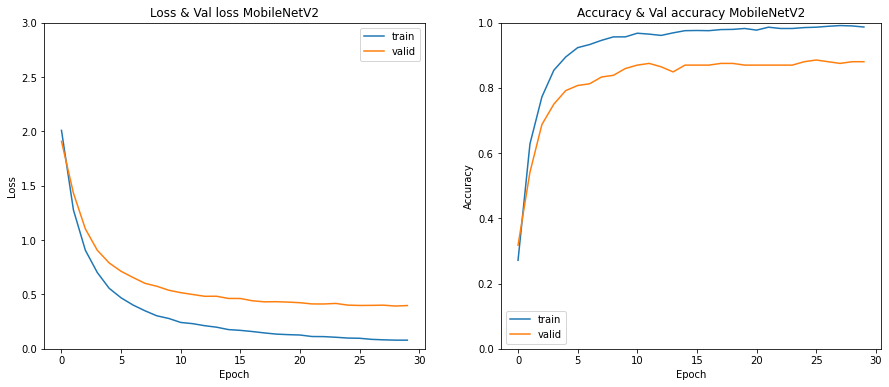

In [ ]:
# PLOT THEM TOGETHER
# Visualization of the learning curves
plt.figure(figsize=(15,6))

# PER IL PLOT DOVRESTI USARE GLI ELEMENTI DERIVANTI DA history_grid_fit_mobilenetV2

plt.subplot(1, 2, 1)
plt.plot(history_mobilenetV2.history['loss'])
plt.plot(history_mobilenetV2.history['val_loss'])
plt.ylim([0.0, 3.0])
plt.title("Loss & Val loss MobileNetV2")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history_mobilenetV2.history['accuracy'])
plt.plot(history_mobilenetV2.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.title("Accuracy & Val accuracy MobileNetV2")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

###### Performance results Model V06 Transfer Learning with MobileNetV2

In [ ]:
# SAVE THE TIME NEEDED TO RUN THE ALGORITHM
time_duration_modelV06_mobilenetV2 = end - start
print(time_duration_modelV06_mobilenetV2)

<IPython.core.display.Javascript object>

0:44:36.507132


In [ ]:
# SAVE THE MODELV05
keras_model_mobilenetV2 = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/saved_models/model_mobilenetV2_FUNZIONANTE.h5"
tf.keras.models.save_model(model_mobilenetv2, keras_model_mobilenetV2)

<IPython.core.display.Javascript object>

In [ ]:
# GET THE MINIMUM ACCURACY, THE MAXIMUM ACCURACY, THE MINIMUM LOSS, THE MAXIMUM LOSS AND SAVE THEM IN VARIABLES.
# THEN CREATE A DATAFRAME AT THE END WHERE YOU CAN COMPARE DIFFERENT MODELS WITH IT!

# LOSS/VAL LOSS
modelVMNV2_minLoss = min(history_mobilenetV2.history['loss'])
modelVMNV2_maxLoss = max(history_mobilenetV2.history['loss'])
modelVMNV2_minValLoss = min(history_mobilenetV2.history['val_loss'])
modelVMNV2_maxValLoss = max(history_mobilenetV2.history['val_loss'])

# ACCURACY/VAL ACCURACY
modelVMNV2_minAccuracy = min(history_mobilenetV2.history['accuracy'])
modelVMNV2_maxAccuracy = max(history_mobilenetV2.history['accuracy'])
modelVMNV2_minValAccuracy = min(history_mobilenetV2.history['val_accuracy'])
modelVMNV2_maxValAccuracy = max(history_mobilenetV2.history['val_accuracy'])

# CREATE THE DATAFRAME
modelVMNV2_loss_accuracy = pd.DataFrame({"minLoss": [modelVMNV2_minLoss],
                                       "maxloss": [modelVMNV2_maxLoss],
                                       "minValLoss": [modelVMNV2_minValLoss],
                                       "maxValLoss": [modelVMNV2_maxValLoss],
                                       "minAccuracy": [modelVMNV2_minAccuracy],
                                       "maxAccuracy": [modelVMNV2_maxAccuracy],
                                       "minValAccuracy": [modelVMNV2_minValAccuracy],
                                       "maxValAccuracy": [modelVMNV2_maxValAccuracy]}).T

# CHANGE THE FIRST COLUMN NAME
modelVMNV2_loss_accuracy = modelVMNV2_loss_accuracy.rename(columns={0: 'modelVMNV2'})
# CHANGE THE INDEX NAME
modelVMNV2_loss_accuracy.index.names = ['Performance']
modelVMNV2_loss_accuracy

<IPython.core.display.Javascript object>

,modelVMNV2
Performance,
minLoss,0.014110
maxloss,0.491862
minValLoss,0.241358
maxValLoss,0.732679
minAccuracy,0.852410
maxAccuracy,0.997323
minValAccuracy,0.816667
maxValAccuracy,0.950000


#### **VGG16**

In [ ]:
# INSERISCI SITO E SPIEGAZIONE COME RIFERIMENTO: https://www.image-net.org/download.php

base_model_VGG16 = tf.keras.applications.vgg16.VGG16(
    input_shape = (SIZE, SIZE, 3),
    # include_top means: do you want to keep the classification layer, the final classification that the original model was training on.
    # MobileNetV2 was originally trained on the ImageNet dataset. Because the final layer has 1000 classes, if we would keep it, we
    # would have 1000 classes at the end. We do not want that but, instead, we want our own classification layer at the end.
    include_top=False, 
    # We keep the same weights
    weights="imagenet"
)
# With the following we ensure that we do not mess with the original
# imagenet weights
base_model_VGG16.trainable = False


x = base_model_VGG16.output
# Average pooling at the end: it will ensure that the output of the pretrained model is one-dimensional (with n classes).
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation='relu')(x)

# We are using "softmax" since we want 9 probability values that all sum to 1 and the highest probability
# will be our classification result.
# For the regularizer: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-l1-l2-and-elastic-net-regularization-with-keras.md
preds = Dense(num_classes, activation='softmax')(x) #final layer with softmax activation for N classes

# OUTPUT THE MODEL
model_VGG16 = keras.Model(inputs = base_model_VGG16.input, outputs = preds) #specify the inputs and outputs

# VISUALIZE THE SUMMARY
print(model_VGG16.summary())

In [ ]:
# COMPILE THE MODEL
model_VGG16.compile(loss=keras.losses.categorical_crossentropy,
                         optimizer= keras.optimizers.Adam(learning_rate=0.0001),
                         metrics=['accuracy', tf.keras.metrics.Recall()])

<IPython.core.display.Javascript object>

In [ ]:
stepsEpochs = train_generator_mnetv2.n // batch_size_CV # 16
valSteps = val_generator_mnetv2.n // batch_size_CV # 16

# START COUNTING THE TIME
start = datetime.datetime.now()


# FIT THE MODEL
history_VGG16 = model_VGG16.fit(train_generator_mnetv2, 
                  validation_data = val_generator_mnetv2, 
                  steps_per_epoch = stepsEpochs,
                  validation_steps = valSteps, 
                  epochs=50) #,
                  # callbacks = [callback])

print("--- Training Completed ---")

# STOP COUNTING THE TIME
end = datetime.datetime.now()
print("Total execution time: ", end-start)

In [ ]:
# PLOT THEM TOGETHER
# Visualization of the learning curves
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(history_VGG16.history['loss'])
plt.plot(history_VGG16.history['val_loss'])
plt.ylim([0.0, 3.0])
plt.title("Loss & Val loss VGG16")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history_VGG16.history['accuracy'])
plt.plot(history_VGG16.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.title("Accuracy & Val accuracy VGG16")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

In [ ]:
# SAVE THE keras_model_VGG16
keras_model_VGG16 = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/saved_models/model_VGG16.h5"
tf.keras.models.save_model(model_VGG16, keras_model_VGG16)

##### Performance results Model V06 Transfer Learning with  VGG16

Convergence much slower than MobileNetV2.

**COMMENTS**

While testing other transfer learning architectures (VGG16, EfficientNetB0, ResNet50), they did not have the same good results as the MobileNetV2.

#### ResNet50

In [ ]:
# INSERISCI SITO E SPIEGAZIONE COME RIFERIMENTO: https://www.image-net.org/download.php

base_model_resnet50 = tf.keras.applications.resnet50.ResNet50(
    input_shape = (SIZE, SIZE, 3),
    # include_top means: do you want to keep the classification layer, the final classification that the original model was training on.
    # MobileNetV2 was originally trained on the ImageNet dataset. Because the final layer has 1000 classes, if we would keep it, we
    # would have 1000 classes at the end. We do not want that but, instead, we want our own classification layer at the end.
    include_top=False, 
    # We keep the same weights
    weights="imagenet",
    # # Average pooling at the end: it will ensure that the output of the pretrained model is one-dimensional (with n classes).
    # pooling="avg"
)
# With the following we ensure that we do not mess with the original
# imagenet weights
base_model_resnet50.trainable = False


x = base_model_resnet50.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation='relu')(x)

# We are using "softmax" since we want 9 probability values that all sum to 1 and the highest probability
# will be our classification result.
# For the regularizer: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-l1-l2-and-elastic-net-regularization-with-keras.md
preds = Dense(num_classes, activation='softmax')(x) #final layer with softmax activation for N classes

# OUTPUT THE MODEL
model_resnet50 = keras.Model(inputs = base_model_resnet50.input, outputs = preds) #specify the inputs and outputs

In [ ]:
stepsEpochs = train_generator_mnetv2.n // batch_size_CV # 16
valSteps = val_generator_mnetv2.n // batch_size_CV # 16

# START COUNTING THE TIME
start = datetime.datetime.now()

# FIT THE MODEL
history_resnet50 = model_resnet50.fit(train_generator_mnetv2,
                                      validation_data = val_generator_mnetv2,
                                      steps_per_epoch = stepsEpochs,
                                      validation_steps = valSteps, 
                                      epochs=30, 
                                      callbacks = [callback])
                  
print("--- Training Completed ---")

# STOP COUNTING THE TIME
end = datetime.datetime.now()
print("Total execution time: ", end-start)

###### Performance results Model V06 Transfer Learning with ResNet50

In [ ]:
# SAVE THE MODELV05
keras_model_resnet50 = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/saved_models/model_resnet50.h5"
tf.keras.models.save_model(model_resnet50, keras_model_resnet50)

## 1.2.8 Model V07 - Transfer learning + PCA

In [ ]:
# # Capture training data and labels into respective lists
# train_images = []
# train_labels = [] 

# # GET THE LABELS
# for directory_path in glob.glob(DIR_TRAIN_DATA):
#     tr_label = directory_path.split("/")[-1]
#     print(tr_label)
#     # GET THE IMAGES
#     for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
#         # print(img_path)
#         img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
#         img = cv2.resize(img, (224, 224))
#         img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
#         train_images.append(img)
#         train_labels.append(tr_label)

# # CONVERT LISTS TO ARRAYS
# train_images = np.array(train_images)
# train_labels = np.array(train_labels)

# ################################################################
# # CAPTURE TEST/VALIDATION DATA AND LABELS INTO RESPECTIVE LISTS

# test_images = []
# test_labels = [] 
# for directory_path in glob.glob(DIR_TEST_DATA):
#     tt_label = directory_path.split("/")[-1]
#     for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
#         img = cv2.imread(img_path, cv2.IMREAD_COLOR)
#         img = cv2.resize(img, (224, 224))
#         img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
#         test_images.append(img)
#         test_labels.append(tt_label)

# #Convert lists to arrays                
# test_images = np.array(test_images)
# test_labels = np.array(test_labels)

In [ ]:
# # ENCODE LABELS FROM TEXT TO INTEGERS
# le = preprocessing.LabelEncoder()

# # TRAIN DATA
# le.fit(train_labels)
# train_labels_encoded = le.transform(train_labels)

# # TEST DATA
# le.fit(test_labels)
# test_labels_encoded = le.transform(test_labels)

# # SPLIT DATA INTO TEST AND TRAIN DATASETS (ALREADY SPLIT BUT ASSIGNING TO MEANINGFUL CONVENTION)
# x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

<IPython.core.display.Javascript object>

In [ ]:
# # SCALE PIXEL VALUES BETWEEN 0 AND 1
# x_train, x_test = x_train / 255.0, x_test / 255.0

# # ONE HOT ENCODE Y VALUES FOR NEURAL NETWORK
# y_train_one_hot = to_categorical(y_train)
# y_test_one_hot = to_categorical(y_test)

<IPython.core.display.Javascript object>

In [ ]:
# #############################
# #Load VGG model with imagenet trained weights and without classifier/fully connected layers
# #We will use this as feature extractor. 
# base_model_mobilenetv2_PCA = tf.keras.applications.MobileNetV2(
#     input_shape = (224, 224, 3),
#     include_top=False, 
#     weights="imagenet"
# )
# # With the following we ensure that we do not mess with the original
# # imagenet weights
# base_model_mobilenetv2_PCA.trainable = False
    
# base_model_mobilenetv2_PCA.summary()  #Trainable parameters will be 0

In [ ]:
# # NOW, USE THE MOBILENETV2 AS A FEATURE EXTRACTOR
# # TRAIN FEATURES
# train_feature_extractor = base_model_mobilenetv2_PCA.predict(x_train)
# train_features = train_feature_extractor.reshape(train_feature_extractor.shape[0], -1)

# # TEST FEATURES
# test_feature_extractor = base_model_mobilenetv2_PCA.predict(x_test)
# test_features = test_feature_extractor.reshape(test_feature_extractor.shape[0], -1)

In [ ]:
# train_features.shape

In [ ]:
# # REDUCE DIMENSIONS USING PCA

# #First verfiy the ideal number of PCA components to not lose much information. 
# #Try to retain 90% information, so look where the curve starts to flatten.
# #Remember that the n_components must be lower than the number of rows or columns (features)
# pca_test = PCA(n_components=900) #
# pca_test.fit(train_features)

In [ ]:
# # Visualization of the cumulative variance plot
# plt.figure(figsize=(15,6))

# # PLOT THE RESULTS
# plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
# plt.xlabel("Number of components")
# plt.ylabel("Cumulative variance")

In [ ]:
# # START COUNTING TIME
# start = datetime.datetime.now()

# #Pick the optimal number of components. This is how many features we will have 
# #for our machine learning
# n_PCA_components = 900
# pca = PCA(n_components=n_PCA_components)
# train_PCA = pca.fit_transform(train_features)
# test_PCA = pca.transform(test_features) #Make sure you are just transforming, not fitting. 

# end = datetime.datetime.now()
# print("Total execution time with PCA is: ", end-start)

In [ ]:
# train_PCA.shape

In [ ]:
# test_PCA.shape

In [ ]:
# ############## Neural Network Approach ##################

# ##Add hidden dense layers and final output/classifier layer.
# model_PCA = Sequential()
# inputs_PCA = keras.layers.Input(shape=(n_PCA_components,)) #Shape = n_components
# hidden_1 = keras.layers.Dense(512, activation='relu')(inputs_PCA)
# hidden_2 = keras.layers.Dense(256, activation='relu')(hidden_1)
# output_PCA = keras.layers.Dense(num_classes, activation='softmax')(hidden_2)
# model_PCA = keras.Model(inputs = inputs_PCA, outputs = output_PCA)

# # PRINT THE SUMMARY
# print(model_PCA.summary())

# # USING A LEARNING RATE DECAY/SCHEDULING --> https://keras.io/api/optimizers/
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate = 0.001, # previously 0.001
#     decay_steps=20000, # previously 10000
#     decay_rate=0.89) # previously 0.95

# # COMPILE THE MODEL
# model_PCA.compile(loss=keras.losses.categorical_crossentropy,
#             optimizer= keras.optimizers.Adam(learning_rate=lr_schedule), # 0.001 # 0.0001
#             metrics=['accuracy'])

In [ ]:
# # START RECORDING TIME
# start = datetime.datetime.now()

# #Fit the model and use on-hot-encoded Y values
# history_model_PCA = model_PCA.fit(train_PCA, 
#                                   y_train_one_hot, 
#                                   epochs = 30, 
#                                   verbose=3,
#                                   validation_data=(test_PCA, y_test_one_hot))

# # END RECORDING TIME
# end = datetime.datetime.now()
# print("Total execution time with PCA is: ", end-start)

In [ ]:
# ##Predict on test dataset
# predict_test_PCA = model_PCA.predict(test_PCA)
# predict_test_PCA = np.argmax(predict_test_PCA, axis=1)
# predict_test_PCA = le.inverse_transform(predict_test_PCA)

In [ ]:
# # PRINT OVERALL ACCURACY
# print ("Accuracy = ", metrics.accuracy_score(test_labels, predict_test_PCA))

In [ ]:
# # START RECORDING TIME
# start = datetime.datetime.now()

# # DEFINE THE K-FOLD CROSS VALIDATOR
# kfold = KFold(n_splits = 10, shuffle=True)

# # DEFINE PER-FOLD SCORE CONTAINERS
# acc_per_fold = []

# # K-FOLD CROSS VALIDATION MODEL EVALUTION
# fold_no = 1
# for train, test in kfold.split(train_PCA, train_PCA):
  
#   ############## NEURAL NETWORK MODEL ##################

#   model_PCA = Sequential()
#   inputs_PCA = keras.layers.Input(shape=(n_PCA_components,)) # Shape = n_components
#   hidden_1 = keras.layers.Dense(256, activation='relu')(inputs_PCA)
#   hidden_2 = keras.layers.Dense(512, activation='relu')(hidden_1)
#   output_PCA = keras.layers.Dense(num_classes, activation='softmax')(hidden_2)
#   model_PCA = keras.Model(inputs = inputs_PCA, outputs = output_PCA)

#   # USING A LEARNING RATE DECAY/SCHEDULING --> https://keras.io/api/optimizers/
#   lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#       initial_learning_rate = 0.001, # previously 0.001
#       decay_steps=20000, # previously 10000
#       decay_rate=0.89) # previously 0.95

#   # COMPILE THE MODEL
#   model_PCA.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer= keras.optimizers.Adam(learning_rate=lr_schedule), # 0.001 # 0.0001
#               metrics=['accuracy'])


#   # GENERATE A MESSAGE
#   print('------------------------------------------------------------------------')
#   print(f'--- Training for fold {fold_no} ---')
 
#   # FIT THE MODEL AND USE ON-HOT ENCODED Y VALUES
#   history_model_PCA = model_PCA.fit(train_PCA, 
#                                     y_train_one_hot, 
#                                     epochs = 30, 
#                                     verbose=3,
#                                     validation_data=(test_PCA, y_test_one_hot))

  
#   # GENERATE GENERALIZATION METRICS
#   ## PREDICT ON TEST DATASET
#   predict_test_PCA = model_PCA.predict(test_PCA)
#   predict_test_PCA = np.argmax(predict_test_PCA, axis=1)
#   predict_test_PCA = le.inverse_transform(predict_test_PCA)

#   # PRINT OVERALL ACCURACY
#   print ("Accuracy = ", metrics.accuracy_score(test_labels, predict_test_PCA))

#   # ACCURACY PER FOLDER
#   acc_per_fold.append(metrics.accuracy_score(test_labels, predict_test_PCA))

#   # INCREASE FOLDER NUMBER
#   fold_no = fold_no + 1

# # END RECORDING TIME
# end = datetime.datetime.now()
# print("Total execution time is: ", end - start)

In [ ]:
# # COMPUTE THE MEAN OF THE ACCURACY FOR THE CROSS VALIDATION FOR MODEL ASSESSMENT
# cv_mean = np.mean(acc_per_fold)
# print("Average accuracy for CV is:", cv_mean)

In [ ]:
# #  VISUALIZATION OF THE CONFUSION MATRIX
# plt.figure(figsize=(15,6))

# # CONFUSION MATRIX - VERIFY ACCURACY OF EACH CLASS

# cm = confusion_matrix(test_labels, predict_test_PCA)
# sns.heatmap(cm, annot=True)

In [ ]:
# # PLOT THEM TOGETHER
# # VISUALIZAZION OF THE LEARNING CURVES
# plt.figure(figsize=(15,6))

# plt.subplot(1, 2, 1)
# plt.plot(history_model_PCA.history['loss'])
# plt.plot(history_model_PCA.history['val_loss'])
# plt.ylim([-0.1, 3.0])
# plt.title("Loss & Val loss Model MobileNetV2 with PCA")
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(['train', 'valid'])

# plt.subplot(1, 2, 2)
# plt.plot(history_model_PCA.history['accuracy'])
# plt.plot(history_model_PCA.history['val_accuracy'])
# plt.ylim([0.0, 1.1])
# plt.title("Accuracy & Val accuracy Model MobileNetV2 with PCA")
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(['train', 'valid'])

#### Test the results over a specified number of images

In [ ]:
# # CHECK RESULTS ON A FEW SELECTED IMAGES

# prediction_list = list() # COLLECT THE PREDICTIONS
# ground_truth_list = list() # COLLECT THE GROUND TRUTH

# for i in range(1, 101): # LOOP THROUGH 10 IMAGES
#   # GET A RANDOM VALUE BETWEEN 0 AND THE THE FIRST DIMENSION OF THE TEST SET
#   n = np.random.randint(0, x_test.shape[0])
#   # GET A RANDOM IMAGE
#   img = x_test[n]
  

#   # INPUT
#   input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
#   input_img_feature = base_model_mobilenetv2_PCA.predict(input_img) # PREDICT THE IMAGE
#   input_img_features = input_img_feature.reshape(input_img_feature.shape[0], -1)
#   input_img_PCA = pca.transform(input_img_features)

#   # PREDICTION
#   prediction_img = model_PCA.predict(input_img_PCA)
#   # GET THE MAX VALUE OF PREDICTION
#   prediction_img = np.argmax(prediction_img, axis=1)
#   # INVERSE TRANSFORM TO GET THE ORIGINAL IMAGE AFTER APPLIED THE PCA
#   prediction_img = le.inverse_transform(prediction_img)  #Reverse the label encoder to original name

#   # PRINT RESULTS
#   # print("The prediction for this image is: ", prediction_img)
#   # print("The actual label for this image is: ", test_labels[n])

#   # COLLECT THE RESULTS
#   prediction_list.append(prediction_img[0])
#   ground_truth_list.append(test_labels[n])
  
#   # INCREASE THE COUNTER
#   # # PLOT THE RANDOM IMAGE
#   # plt.imshow(img)

#   i += 1


# # CREATE A DATAFRAME TO COMPARE THE RESULTS
# df_comparison = pd.DataFrame({"predicted": prediction_list, "ground truth": ground_truth_list})

In [ ]:
# df_comparison['comparison'] = np.where(df_comparison['predicted'] == df_comparison['ground truth'], 1, 
#                                       np.where(df_comparison['predicted'] !=  df_comparison['ground truth'], 0, -1))

# # df_comparison

In [ ]:
# # COMPUTE ACCURACY OVER THE TEN ELEMENTS
# accuracy_over_test = (np.sum(df_comparison['comparison'])/len(df_comparison))*100
# print(f"Accuracy over {len(df_comparison)} images is:", accuracy_over_test, "%")

#### Performance results Model V07 Transfer Learning + PCA

In [ ]:
# # SAVE THE TIME NEEDED TO RUN THE ALGORITHM
# time_duration_modelV07_cv = end - start
# print(time_duration_modelV07_cv)

In [ ]:
# WE ARE NOT SAVING THIS MODEL, IT WAS JUST A TEST TO COMPARE TO THE TRANSFER LEARNING

In [ ]:
# # GET THE MINIMUM ACCURACY, THE MAXIMUM ACCURACY, THE MINIMUM LOSS, THE MAXIMUM LOSS AND SAVE THEM IN VARIABLES.
# # THEN CREATE A DATAFRAME AT THE END WHERE YOU CAN COMPARE DIFFERENT MODELS WITH IT!

# # LOSS/VAL LOSS
# modelV07_GDCV_minLoss = min(history_model_PCA.history['loss'])
# modelV07_GDCV_maxLoss = max(history_model_PCA.history['loss'])
# modelV07_GDCV_minValLoss = min(history_model_PCA.history['val_loss'])
# modelV07_GDCV_maxValLoss = max(history_model_PCA.history['val_loss'])

# # ACCURACY/VAL ACCURACY
# modelV07_GDCV_minAccuracy = min(history_model_PCA.history['accuracy'])
# modelV07_GDCV_maxAccuracy = max(history_model_PCA.history['accuracy'])
# modelV07_GDCV_minValAccuracy = min(history_model_PCA.history['val_accuracy'])
# modelV07_GDCV_maxValAccuracy = max(history_model_PCA.history['val_accuracy'])

# # CREATE THE DATAFRAME
# modelV07_GDCV_loss_accuracy = pd.DataFrame({"minLoss": [modelV07_GDCV_minLoss],
#                                        "maxloss": [modelV07_GDCV_maxLoss],
#                                        "minValLoss": [modelV07_GDCV_minValLoss],
#                                        "maxValLoss": [modelV07_GDCV_maxValLoss],
#                                        "minAccuracy": [modelV07_GDCV_minAccuracy],
#                                        "maxAccuracy": [modelV07_GDCV_maxAccuracy],
#                                        "minValAccuracy": [modelV07_GDCV_minValAccuracy],
#                                        "maxValAccuracy": [modelV07_GDCV_maxValAccuracy]}).T

# # CHANGE THE FIRST COLUMN NAME
# modelV07_GDCV_loss_accuracy = modelV07_GDCV_loss_accuracy.rename(columns={0: 'modelV07_GDCV'})
# # CHANGE THE INDEX NAME
# modelV07_GDCV_loss_accuracy.index.names = ['Performance']
# modelV07_GDCV_loss_accuracy

## 1.2.9 Save the performances of all the models

**DA RICONTROLLARE IL SALVATAGGIO DEL TIME E DEL MODELLO ACCURACY. SALVA SOLAMENTE QUELLO DEI MODELLI PRINCIPALI E NON DELLGRIDSEARCH. LA GRIDSEARCH IN QUESTO CASO LA VAI AD UTILIZZARE SOLAMENTE COME METODO PER CERCARE I MIGLIORI VALORI, TUTTO LI. I MIGLIORI VALORI POI LI UTILIZZI CON LA MOBILENETV2 NEL TRANSFER LEARNING!**

In [ ]:
# COMPATTA IN UN DATAFRAME/SERIE IL TEMPO PER OGNI MODELLO, POI TRASPONI E POI
# AGGANCIA COME ULTIMA RIGA AL DATAFRAME MERGIATO SEGUENTE
timing_df = pd.DataFrame({"timing": [time_duration_modelV01,
                                     time_duration_modelV02,
                                     time_duration_modelV03,
                                     time_duration_modelV04,
                                    #  time_duration_modelV04_gridsearchCV,
                                    #  time_duration_modelV05_gridsearchcv,
                                     time_duration_modelV06_mobilenetV2]}).T
                                    #  time_duration_modelV07_cv]}).T

# CONCATENATE ALL THE PERFORMANCE DATAFRAME
final_accuracy_df = pd.concat([modelV01_loss_accuracy, 
                               modelV02_loss_accuracy, 
                               modelV03_loss_accuracy, 
                               modelV04_loss_accuracy, 
                              #  modelV04_GDCV_loss_accuracy, 
                               modelVMNV2_loss_accuracy])
                              #  modelV07_GDCV_loss_accuracy])

data_acc_timing = [final_accuracy_df, timing_df]
df_performance = pd.concat(data_acc_timing, axis = 0)
df_performance

# 2 Models persistence

### Save all the models and load the best one again in the TEST notebook in order to use it.

### RICONTROLLARE IL SALVATAGGIO DI QUESTI MODELLI!!!!!!!!

In [ ]:
# SAVE THE MODEL V01
keras_file_modelV01 = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/saved_models/modelV01.h5"
tf.keras.models.save_model(net_modelV01, keras_file_modelV01) # MODIFY MODEL WITH YOUR OWN MODEL

# SAVE THE MODEL V02
keras_file_modelV02 = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/saved_models/modelV02.h5"
tf.keras.models.save_model(net_modelV02, keras_file_modelV02) # MODIFY MODEL WITH YOUR OWN MODEL

# SAVE THE MODEL V03
keras_file_modelV03 = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/saved_models/modelV03.h5"
tf.keras.models.save_model(net_modelV03, keras_file_modelV03) # MODIFY MODEL WITH YOUR OWN MODEL

# SAVE THE MODEL V04
keras_file_modelV04 = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/saved_models/modelV04.h5"
tf.keras.models.save_model(net_modelv04, keras_file_modelV04) # MODIFY MODEL WITH YOUR OWN MODEL

# # SAVE THE MODELV04 GRIDSEARCHCV
# keras_file_modelV04_gridsearchCV = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/saved_models/modelV04_GSCV.h5"
# tf.keras.models.save_model(net_modelvGSCV, keras_file_modelV04_gridsearchCV) # MODIFY MODEL WITH YOUR OWN MODEL

# SAVE THE MODELV05 GRIDSEARCHCV
keras_file_modelV05_gridsearchCV = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/saved_models/model_gridsearchCV.h5"
tf.keras.models.save_model(create_GSCV_model(), keras_file_modelV05_gridsearchCV) # MODIFY MODEL WITH YOUR OWN MODEL

# SAVING THE TRANSFER LEARNING MODEL CALLED mobilenetV2.h5
keras_file_mobilenetV2 = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/saved_models/mobilenetV2.h5"
tf.keras.models.save_model(model_mobilenetv2, keras_file_mobilenetV2) # MODIFY MODEL WITH YOUR OWN MODEL



---



---

